# World Bank Data ETL Pipeline

In [0]:
# For ps.read_excel to work
!pip install xlrd

     |████████████████████████████████| 96 kB 3.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b4d91e44-8ba8-48e3-9c34-1de5b12c3ed6/bin/python -m pip install --upgrade pip' command.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType
from pyspark.sql.functions import col, isnan, when, count, split, lit, create_map, sum, regexp_replace, to_timestamp

In [0]:
# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("World Bank Data Pipeline") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:3.5.1_0.20.4") \
    .getOrCreate()

## Extract

### Extracting data from csv

Reading data about World Bank projects

In [0]:
pandas_df_projects = ps.read_excel("/FileStore/tables/world_bank_data/Projects.xls")
print(pandas_df_projects)

/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: convert_float is deprecated and will be removed in a future version.
  return pd.read_excel(
/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  return pd.read_excel(


---------------------------------------------------------------------------
ArrowTypeError                            Traceback (most recent call last)
File <command-2677012391446207>:1
----> 1 pandas_df_projects = ps.read_excel("/FileStore/tables/world_bank_data/Projects.xls")
      2 print(pandas_df_projects)

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/pandas/namespace.py:1172, in read_excel(io, sheet_name, header, names, index_col, usecols, squeeze, dtype, engine, converters, true_values, false_values, skiprows, nrows, na_values, keep_default_na, verbose, parse_dates, date_parser, thousands, comment, skipfooter, convert_f

Pandas isn't able to automatically detect the data type of the columns. So we read the data as strings.

In [0]:
# Read with pyspark pandas as normal pandas cannot read from DBFS
pandas_df_projects = ps.read_excel("/FileStore/tables/world_bank_data/Projects.xls", dtype = str)
print(pandas_df_projects.head())

/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: convert_float is deprecated and will be removed in a future version.
  return pd.read_excel(
/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  return pd.read_excel(


  World Bank Projects, data as of 03/23/2022 22:00:01 EST                    Unnamed: 1                     Unnamed: 2            Unnamed: 3                                                                                                                       Unnamed: 4                                                                                                                                         Unnamed: 5                                                  Unnamed: 6                    Unnamed: 7                                          Unnamed: 8            Unnamed: 9           Unnamed: 10           Unnamed: 11           Unnamed: 12           Unnamed: 13          Unnamed: 14                    Unnamed: 15   Unnamed: 16                                     Unnamed: 17                   Unnamed: 18                        Unnamed: 19                    Unnamed: 20 Unnamed: 21 Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25
0                                              Project ID    

In [0]:
# Columns were wrong. Setting actual columns which is the first row in dataframe
pandas_df_projects.columns = pandas_df_projects.iloc[0]
print(pandas_df_projects.columns)

Index(['Project ID', 'Region', 'Country', 'Project Status', 'Project Name',
       'Project Development Objective ', 'Implementing Agency',
       'Consultant Services Required', 'Project URL', 'Board Approval Date',
       'Project Closing Date', 'Financing Type', 'Current Project Cost',
       'IBRD Commitment ', 'IDA Commitment', 'Total IDA and IBRD Commitment',
       'Grant Amount', 'Borrower', 'Lending Instrument',
       'Environmental Assessment Category', 'Environmental and Social Risk',
       'Sector 1', 'Sector 2', 'Sector 3', 'Theme 1', 'Theme 2'],
      dtype='object')


In [0]:
# Deleting the first row which contained columns names
pandas_df_projects = pandas_df_projects.drop(index = 1)
pandas_df_projects = pandas_df_projects.drop(index = 0)
print(pandas_df_projects.head())

  Project ID                        Region                        Country Project Status                                                                                                                     Project Name                                                                                                                                                                                                                                                       Project Development Objective                                          Implementing Agency Consultant Services Required                                         Project URL   Board Approval Date  Project Closing Date Financing Type Current Project Cost IBRD Commitment  IDA Commitment Total IDA and IBRD Commitment Grant Amount                                        Borrower            Lending Instrument Environmental Assessment Category Environmental and Social Risk Sector 1 Sector 2 Sector 3 Theme 1 Theme 2
2    P174708  Middle Eas

In [0]:
print(pandas_df_projects.head())

  Project ID                        Region                        Country Project Status                                                                                                                     Project Name                                                                                                                                                                                                                                                       Project Development Objective                                          Implementing Agency Consultant Services Required                                         Project URL   Board Approval Date  Project Closing Date Financing Type Current Project Cost IBRD Commitment  IDA Commitment Total IDA and IBRD Commitment Grant Amount                                        Borrower            Lending Instrument Environmental Assessment Category Environmental and Social Risk Sector 1 Sector 2 Sector 3 Theme 1 Theme 2
2    P174708  Middle Eas

In [0]:
print(pandas_df_projects.dtypes)

Project ID                           object
Region                               object
Country                              object
Project Status                       object
Project Name                         object
Project Development Objective        object
Implementing Agency                  object
Consultant Services Required         object
Project URL                          object
Board Approval Date                  object
Project Closing Date                 object
Financing Type                       object
Current Project Cost                 object
IBRD Commitment                      object
IDA Commitment                       object
Total IDA and IBRD Commitment        object
Grant Amount                         object
Borrower                             object
Lending Instrument                   object
Environmental Assessment Category    object
Environmental and Social Risk        object
Sector 1                             object
Sector 2                        

In [0]:
# Converting pandas dataframe to spark dataframe
schema_fields = []

for column in pandas_df_projects.columns:
    schema_fields.append(StructField(f"{column}", StringType(), True))

df_projects_schema = StructType(schema_fields)

pandas_df_as_tuples = [tuple(row) for row in pandas_df_projects.values]

df_projects = spark.createDataFrame(data = pandas_df_as_tuples, schema = df_projects_schema)
df_projects.show()

/databricks/spark/python/pyspark/pandas/generic.py:648: UserWarning: We recommend using `DataFrame.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))


+----------+--------------------+--------------------+--------------+--------------------+------------------------------+--------------------+----------------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------------+--------------+-----------------------------+------------+--------------------+--------------------+---------------------------------+-----------------------------+--------+--------+--------+-------+-------+
|Project ID|              Region|             Country|Project Status|        Project Name|Project Development Objective | Implementing Agency|Consultant Services Required|         Project URL| Board Approval Date|Project Closing Date|Financing Type|Current Project Cost|IBRD Commitment |IDA Commitment|Total IDA and IBRD Commitment|Grant Amount|            Borrower|  Lending Instrument|Environmental Assessment Category|Environmental and Social Risk|Sector 1|Sector 2|Sector 3|Theme 1|Theme 2|
+---------

Counting the null values in each column of the population dataframe

In [0]:
df_projects.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_projects.columns]
   ).show(truncate = False, vertical = True)

-RECORD 0----------------------------------
 Project ID                        | 0     
 Region                            | 2     
 Country                           | 2     
 Project Status                    | 2     
 Project Name                      | 0     
 Project Development Objective     | 9966  
 Implementing Agency               | 14939 
 Consultant Services Required      | 20038 
 Project URL                       | 0     
 Board Approval Date               | 2874  
 Project Closing Date              | 5022  
 Financing Type                    | 8613  
 Current Project Cost              | 147   
 IBRD Commitment                   | 0     
 IDA Commitment                    | 0     
 Total IDA and IBRD Commitment     | 0     
 Grant Amount                      | 0     
 Borrower                          | 15171 
 Lending Instrument                | 248   
 Environmental Assessment Category | 8391  
 Environmental and Social Risk     | 20277 
 Sector 1                       

In [0]:
df_projects.select([count(when(col(c).contains('None') | \
                                col(c).contains('NULL') | \
                                (col(c) == '' ) | \
                                col(c).isNull() | \
                                isnan(c), c 
                                )).alias(c) for c in df_projects.columns]).show(truncate = False, vertical = True)

-RECORD 0----------------------------------
 Project ID                        | 0     
 Region                            | 2     
 Country                           | 2     
 Project Status                    | 2     
 Project Name                      | 0     
 Project Development Objective     | 9968  
 Implementing Agency               | 14939 
 Consultant Services Required      | 20038 
 Project URL                       | 0     
 Board Approval Date               | 2874  
 Project Closing Date              | 5022  
 Financing Type                    | 8613  
 Current Project Cost              | 147   
 IBRD Commitment                   | 0     
 IDA Commitment                    | 0     
 Total IDA and IBRD Commitment     | 0     
 Grant Amount                      | 0     
 Borrower                          | 15172 
 Lending Instrument                | 248   
 Environmental Assessment Category | 8391  
 Environmental and Social Risk     | 20277 
 Sector 1                       

Shape of projects dataframe

In [0]:
print(f"(Rows, Columns) :  ({df_projects.count()}), {len(df_projects.columns)})")

(Rows, Columns) :  (21474), 26)


Reading population data

In [0]:
pandas_df_population = ps.read_excel("/FileStore/tables/world_bank_data/population.xls")

/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: convert_float is deprecated and will be removed in a future version.
  return pd.read_excel(
/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  return pd.read_excel(


---------------------------------------------------------------------------
ArrowTypeError                            Traceback (most recent call last)
File <command-4444243048391605>:1
----> 1 pandas_df_population = ps.read_excel("/FileStore/tables/world_bank_data/population.xls")

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/pandas/namespace.py:1172, in read_excel(io, sheet_name, header, names, index_col, usecols, squeeze, dtype, engine, converters, true_values, false_values, skiprows, nrows, na_values, keep_default_na, verbose, parse_dates, date_parser, thousands, comment, skipfooter, convert_float, mangle_dupe_cols, **kwds

Data is not being read correctly. On checking the file, it could be because the first 3 lines have unwanted info which is not required.

In [0]:
# Reading the excel but skipping the first 3 lines
pandas_df_population = ps.read_excel("/FileStore/tables/world_bank_data/population.xls", skiprows = 3)
print(pandas_df_population.head())

/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: convert_float is deprecated and will be removed in a future version.
  return pd.read_excel(
/databricks/spark/python/pyspark/pandas/namespace.py:1126: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  return pd.read_excel(


                  Country Name Country Code     Indicator Name Indicator Code         1960         1961         1962         1963         1964         1965         1966         1967         1968         1969         1970         1971         1972         1973         1974         1975         1976         1977         1978         1979         1980         1981         1982         1983         1984         1985         1986         1987         1988         1989         1990         1991         1992         1993         1994         1995         1996         1997         1998         1999         2000         2001         2002         2003         2004         2005         2006         2007         2008         2009         2010         2011         2012         2013         2014         2015         2016         2017         2018         2019         2020
0                        Aruba          ABW  Population, total    SP.POP.TOTL      54208.0      55434.0      56234.0      56699.0

In [0]:
# Converting pandas dataframe to spark dataframe
schema_fields = []

for column in pandas_df_population.columns:
    schema_fields.append(StructField(f"{column}", StringType(), True))

df_population_schema = StructType(schema_fields)

pandas_df_as_tuples = [tuple(row) for row in pandas_df_population.values]

df_population = spark.createDataFrame(data = pandas_df_as_tuples, schema = df_population_schema)
df_population.show()

/databricks/spark/python/pyspark/pandas/generic.py:648: UserWarning: We recommend using `DataFrame.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))


+--------------------+------------+-----------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|        Country Name|Country Code|   Indicator Name|Indicator Code|        1960|        1961|        1962|        1963|        1964|     

Counting the null values in each column of the population dataframe

In [0]:
# Pandas
pandas_df_population.isnull().sum()

Out[84]: Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              2
1961              2
1962              2
1963              2
1964              2
1965              2
1966              2
1967              2
1968              2
1969              2
1970              2
1971              2
1972              2
1973              2
1974              2
1975              2
1976              2
1977              2
1978              2
1979              2
1980              2
1981              2
1982              2
1983              2
1984              2
1985              2
1986              2
1987              2
1988              2
1989              2
1990              1
1991              1
1992              2
1993              2
1994              2
1995              1
1996              1
1997              1
1998              1
1999              1
2000              1
2001              1
2002              1
2003              1
2004              1
2005       

In [0]:
# Spark
df_population.select([count(when(col(c).contains('None') | \
                                col(c).contains('NULL') | \
                                (col(c) == '' ) | \
                                col(c).isNull() | \
                                isnan(c), c 
                                )).alias(c) for c in df_population.columns]).show(truncate = False, vertical = True)

-RECORD 0-------------
 Country Name   | 0   
 Country Code   | 0   
 Indicator Name | 0   
 Indicator Code | 0   
 1960           | 2   
 1961           | 2   
 1962           | 2   
 1963           | 2   
 1964           | 2   
 1965           | 2   
 1966           | 2   
 1967           | 2   
 1968           | 2   
 1969           | 2   
 1970           | 2   
 1971           | 2   
 1972           | 2   
 1973           | 2   
 1974           | 2   
 1975           | 2   
 1976           | 2   
 1977           | 2   
 1978           | 2   
 1979           | 2   
 1980           | 2   
 1981           | 2   
 1982           | 2   
 1983           | 2   
 1984           | 2   
 1985           | 2   
 1986           | 2   
 1987           | 2   
 1988           | 2   
 1989           | 2   
 1990           | 1   
 1991           | 1   
 1992           | 2   
 1993           | 2   
 1994           | 2   
 1995           | 1   
 1996           | 1   
 1997           | 1   
 1998      

Every column has at least one null value.

Now checking along the rows.

In [0]:
# Pandas
print(f"Shape: {pandas_df_population.shape}")
print(f"No. of null values in each row:-\n{pandas_df_population.isnull().sum(axis = 1)}")

Shape: (266, 65)
No. of null values in each row:-
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      0
60      0
61      0
62      0
63      0
64      0
65      0
66      0
67      0
68      0
69      9
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      0
78      0
79      0
80      0
81      0
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      0
92      0
93      0
94      0


In [0]:
# ps.set_option('display.max_columns', None)
ps.set_option('display.max_rows', None)         # Attempted to prevent truncation of column values

In [0]:
# Displaying the rows that have null values
print(f"110th record:\n{pandas_df_population.iloc[110]}")

110th record:
Country Name         Not classified
Country Code                    INX
Indicator Name    Population, total
Indicator Code          SP.POP.TOTL
1960                            NaN
                        ...        
2016                            NaN
2017                            NaN
2018                            NaN
2019                            NaN
2020                            NaN
Name: 110, Length: 65, dtype: object


In [0]:
# 196th record does not have records until 1989
print(f"196th record:\n{pandas_df_population.iloc[196, :40]}")

196th record:
Country Name      West Bank and Gaza
Country Code                     PSE
Indicator Name     Population, total
Indicator Code           SP.POP.TOTL
1960                             NaN
1961                             NaN
1962                             NaN
1963                             NaN
1964                             NaN
1965                             NaN
1966                             NaN
1967                             NaN
1968                             NaN
1969                             NaN
1970                             NaN
1971                             NaN
1972                             NaN
1973                             NaN
1974                             NaN
1975                             NaN
1976                             NaN
1977                             NaN
1978                             NaN
1979                             NaN
1980                             NaN
1981                             NaN
1982                    

In [0]:
# Spark
# Map Reduce method wasn't able to find NaN values
# df_population.rdd.map(lambda x: (x[0], x.count(None))).toDF(['id','numNulls']).show(n = df_population.count())

print(
    df_population.withColumn(
        "NaN_Count",
        sum(when(isnan(col(c)) | col(c).isNull(), 1).otherwise(0) for c in df_population.columns)
    ).select("Country Name", "NaN_Count").show(n = df_population.count())
)             

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-4320078421581006>:8
      1 # Spark
      2 # Map Reduce method wasn't able to find NaN values
      3 # df_population.rdd.map(lambda x: (x[0], x.count(None))).toDF(['id','numNulls']).show(n = df_population.count())
      5 print(
      6     df_population.withColumn(
      7         "NaN_Count",
----> 8         sum(when(isnan(col(c)) | col(c).isNull(), 1).otherwise(0) for c in df_population.columns)
      9     ).select("Country Name", "NaN_Count").show(n = df_population.count())
     10 )

File /databricks/spark/python/pyspark/sql/utils.py:164, in try_remote_functions.<locals>.wrapped(*args, **kwargs)
    162     return getattr(functions, f.__name__)(*args, **kwargs)
    163 else:
--> 164     return f(*args, **kwargs)

File /databricks/spark/python/pyspark/sql/functions.py:602, in sum(col)
    572 @try_remote_functions
 

In [0]:
# Displaying the rows that have null values
print(f"110th record:")
df_population.where(df_population['Country Name'] == 'Not classified').show()

110th record:
+--------------+------------+-----------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  Country Name|Country Code|   Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|
+--------------+------------+-----------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---

In [0]:
print(f"196th record:")
df_population.where(df_population['Country Name'] == 'West Bank and Gaza').show()

196th record:
+------------------+------------+-----------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|      Country Name|Country Code|   Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|     1990|     1991|     1992|     1993|     1994|     1995|     1996|     1997|     1998|     1999|     2000|     2001|     2002|     2003|     2004|     2005|     2006|     2007|     2008|     2009|     2010|     2011|     2012|     2013|   

Dropping the row with completely NaN values. 

In [0]:
pandas_df_population = pandas_df_population.drop(index = ['110'], axis=1)

In [0]:
print(f"Checking the Pandas dataframe after dropping the row with NaN values:\n{pandas_df_population.iloc[110]}")

Checking the Pandas dataframe after dropping the row with NaN values:
Country Name                Ireland
Country Code                    IRL
Indicator Name    Population, total
Indicator Code          SP.POP.TOTL
1960                      2828600.0
                        ...        
2016                      4755335.0
2017                      4807388.0
2018                      4867316.0
2019                      4934340.0
2020                      4994724.0
Name: 111, Length: 65, dtype: object


In [0]:
df_population = df_population.filter(df_population["Country Name"] != "Not classified")

In [0]:
print(f"Checking the Spark dataframe after dropping the row with NaN values:")
df_population.filter(df_population["Country Name"] == "Not classified").show()

Checking the Spark dataframe after dropping the row with NaN values:
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---

### Extract Data from JSON

In [0]:
# Using pandas
pandas_df_population_json = ps.read_json('/FileStore/tables/world_bank_data/population_data.json',orient='records')
pandas_df_population_json.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Country Code,Country Name,Indicator Code,Indicator Name
0,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,58386.0,58726.0,59063.0,59440.0,59840.0,60243.0,60528.0,60657.0,60586.0,60366.0,60103.0,59980.0,60096.0,60567.0,61345.0,62201.0,62836.0,63026.0,62644.0,61833.0,61079.0,61032.0,62149.0,64622.0,68235.0,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,97017.0,98737.0,100031.0,100832.0,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0,ABW,Aruba,SP.POP.TOTL,"Population, total"
1,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,10604346.0,10854428.0,11126123.0,11417825.0,11721940.0,12027822.0,12321541.0,12590286.0,12840299.0,13067538.0,13237734.0,13306695.0,13248370.0,13053954.0,12749645.0,12389269.0,12047115.0,11783050.0,11601041.0,11502761.0,11540888.0,11777609.0,12249114.0,12993657.0,13981231.0,15095099.0,16172719.0,17099541.0,17822884.0,18381605.0,18863999.0,19403676.0,20093756.0,20966463.0,21979923.0,23064851.0,24118979.0,25070798.0,25893450.0,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0,AFG,Afghanistan,SP.POP.TOTL,"Population, total"
2,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,6523791.0,6642632.0,6776381.0,6927269.0,7094834.0,7277960.0,7474338.0,7682479.0,7900997.0,8130988.0,8376147.0,8641521.0,8929900.0,9244507.0,9582156.0,9931562.0,10277321.0,10609042.0,10921037.0,11218268.0,11513968.0,11827237.0,12171441.0,12553446.0,12968345.0,13403734.0,13841301.0,14268994.0,14682284.0,15088981.0,15504318.0,15949766.0,16440924.0,16983266.0,17572649.0,18203369.0,18865716.0,19552542.0,20262399.0,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0,AGO,Angola,SP.POP.TOTL,"Population, total"
3,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,2022272.0,2081695.0,2135479.0,2187853.0,2243126.0,2296752.0,2350124.0,2404831.0,2458526.0,2513546.0,2566266.0,2617832.0,2671997.0,2726056.0,2784278.0,2843960.0,2904429.0,2964762.0,3022635.0,3083605.0,3142336.0,3227943.0,3286542.0,3266790.0,3247039.0,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,3039616.0,3026939.0,3011487.0,2992547.0,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,ALB,Albania,SP.POP.TOTL,"Population, total"
4,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,21890.0,23058.0,24276.0,25559.0,26892.0,28232.0,29520.0,30705.0,31777.0,32771.0,33737.0,34818.0,36067.0,37500.0,39114.0,40867.0,42706.0,44600.0,46517.0,48455.0,50434.0,52448.0,54509.0,56671.0,58888.0,60971.0,62677.0,63850.0,64360.0,64327.0,64142.0,64370.0,65390.0,67341.0,70049.0,73182.0,76244.0,78867.0,80991.0,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0,AND,Andorra,SP.POP.TOTL,"Population, total"


In [0]:
# Using spark
df_population_json = spark.read.json("dbfs:/FileStore/tables/world_bank_data/population_data.json")
df_population_json.show(vertical = True)

-RECORD 0------------------------------
 1960           | 54211.0              
 1961           | 55438.0              
 1962           | 56225.0              
 1963           | 56695.0              
 1964           | 57032.0              
 1965           | 57360.0              
 1966           | 57715.0              
 1967           | 58055.0              
 1968           | 58386.0              
 1969           | 58726.0              
 1970           | 59063.0              
 1971           | 59440.0              
 1972           | 59840.0              
 1973           | 60243.0              
 1974           | 60528.0              
 1975           | 60657.0              
 1976           | 60586.0              
 1977           | 60366.0              
 1978           | 60103.0              
 1979           | 59980.0              
 1980           | 60096.0              
 1981           | 60567.0              
 1982           | 61345.0              
 1983           | 62201.0              


### Extract Data from API

In [0]:
import requests

url = 'http://api.worldbank.org/v2/countries/br;cn;us;de/indicators/SP.POP.TOTL/?format=json&per_page=1000'
r = requests.get(url)
r.json()

Out[99]: [{'page': 1,
  'pages': 1,
  'per_page': 1000,
  'total': 256,
  'sourceid': '2',
  'lastupdated': '2024-12-16'},
 [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2023',
   'value': 211140729,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2022',
   'value': 210306415,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date': '2021',
   'value': 209550294,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'BR', 'value': 'Brazil'},
   'countryiso3code': 'BRA',
   'date'

In [0]:
ps.set_option('display.max_rows', 10)  
ps.DataFrame(r.json()[1])

/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  A field of type StructType expects a pandas.DataFrame, but got: <class 'pandas.core.series.Series'>
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2023,211140729,,,0
1,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2022,210306415,,,0
2,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2021,209550294,,,0
3,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2020,208660842,,,0
4,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2019,207455459,,,0
5,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2018,206107261,,,0
6,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2017,204703445,,,0
7,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2016,203218114,,,0
8,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2015,201675532,,,0
9,"{'id': 'SP.POP.TOTL', 'value': 'Population, to...","{'id': 'BR', 'value': 'Brazil'}",BRA,2014,200085127,,,0


The country and indicator variables don't look particularly useful in their current form. Again, dealing with those issues would come in the transformation phase of a pipeline.

Using the Indicators API to request rural population data for Switzerland in the years 1995 through 2001. Here are a few helpful resources:
- Documentation about how to filter by year (https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structure)
- 2-character iso country codes (https://www.nationsonline.org/oneworld/country_code_list.htm)
- Search box for World Bank indicators (https://data.worldbank.org/)

In [0]:
url = 'http://api.worldbank.org/v2/country/CH/indicator/SP.POP.TOTL/?format=json&date=1995:2001'

r = requests.get(url)
r.json()

Out[101]: [{'page': 1,
  'pages': 1,
  'per_page': 50,
  'total': 7,
  'sourceid': '2',
  'lastupdated': '2024-12-16'},
 [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2001',
   'value': 7229854,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '2000',
   'value': 7184250,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE',
   'date': '1999',
   'value': 7143991,
   'unit': '',
   'obs_status': '',
   'decimal': 0},
  {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
   'country': {'id': 'CH', 'value': 'Switzerland'},
   'countryiso3code': 'CHE'

## Transform

### Combining Data

There are two csv files:
- rural_population_percent.csv
- electricity_access_percent.csv

The rural populaton data represents the percent of a country's population that is rural over time. The electricity access data shows the percentage of people with access to electricity.

Combining these two data sets together into one data frame.

Rural Population Percent

In [0]:
# Reading csv with pandas, skipping first 4 rows as they are either blank or have unwanted info.
pandas_df_rural = ps.read_csv('/FileStore/tables/world_bank_data/rural_population_percent.csv',skiprows = 4)
pandas_df_rural.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,49.315,49.330,49.346,49.361,49.376,49.391,49.407,49.422,49.437,49.452,49.468,49.483,49.498,49.513,49.528,49.544,49.559,49.574,49.589,49.605,49.620,49.635,49.650,49.665,49.681,49.696,50.002,50.412,50.823,51.233,51.644,52.054,52.464,52.873,53.283,53.661,54.028,54.394,54.760,55.125,55.489,55.853,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,89.915,89.570,89.214,88.848,88.471,88.083,87.684,87.274,86.851,86.417,85.971,85.513,85.042,84.565,84.319,84.070,83.818,83.563,83.304,83.042,82.777,82.509,82.237,81.962,81.684,81.403,81.118,80.830,80.538,80.243,79.945,79.644,79.339,79.030,78.718,78.404,78.085,77.763,77.438,77.105,76.763,76.413,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,87.035,86.559,86.068,85.564,85.043,84.566,84.125,83.676,83.215,82.745,82.263,81.772,81.270,80.758,80.234,79.701,79.157,78.602,78.035,77.459,76.872,76.275,75.666,75.048,74.418,73.779,73.128,72.470,71.800,71.120,70.430,69.732,69.025,68.308,67.581,66.848,66.105,65.355,64.595,63.831,63.058,62.278,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,68.698,68.626,68.554,68.452,68.260,68.067,67.873,67.679,67.484,67.288,67.092,66.895,66.698,66.500,66.238,65.976,65.713,65.448,65.183,64.917,64.650,64.381,64.112,63.842,63.572,63.300,62.751,62.201,61.646,61.089,60.527,59.965,59.399,58.831,58.259,57.565,56.499,55.427,54.349,53.269,52.185,51.098,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,27.407,25.359,23.412,21.576,19.845,18.220,16.699,15.284,13.968,12.748,11.618,10.580,9.622,8.743,7.936,7.200,6.526,5.911,5.351,4.841,4.675,4.822,4.973,5.128,5.288,5.470,5.676,5.889,6.110,6.339,6.575,6.820,7.073,7.334,7.605,7.944,8.359,8.793,9.249,9.705,10.162,10.637,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873


In [0]:
# Using spark to read the csv, but have to convert to text file to try and skip first 4 rows 

rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/rural_population_percent.csv")

# Skip the first 4 rows
filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 3).keys()
# zipWithIndex() -> a pair with the row values in the first and the index starting from 0 in the second
# filter -> to get only those values that have second value in pair greater than 3
# keys() -> Taking the first value from each pair in the output

# Convert back to a DataFrame
df_rural = spark.read.csv(filtered_rdd, header=True)
df_rural.show()

+--------------------+------------+--------------------+--------------+----------------+----------------+---------------+----------------+----------------+---------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------

Electricity Access Percent

In [0]:
# Using Pandas, skiping fist 4 rows
pandas_df_electricity = ps.read_csv('/FileStore/tables/world_bank_data/electricity_access_percent.csv', skiprows = 4)
pandas_df_electricity.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,88.445351,88.780846,89.115829,89.447754,89.773560,90.090187,90.394585,90.683678,90.954422,91.203751,91.660398,91.638092,91.833717,92.023048,92.212166,92.407120,92.613983,92.838821,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,None
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.021977,0.179635,0.959756,0.776537,6.267394,11.751966,17.236319,23.000000,28.228613,33.748680,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,None
2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,11.397808,12.579379,13.760440,14.938441,16.110325,17.273031,18.423502,19.558676,20.675495,21.770901,22.843355,20.000000,24.939095,25.974508,27.009701,28.050735,29.103676,37.500000,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,None
3,Albania,ALB,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,None
4,Andorra,AND,Access to electricity (% of population),EG.ELC.ACCS.ZS,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,None


In [0]:
# Using spark to read the csv, but have to convert to text file to try and skip first 4 rows 

rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/electricity_access_percent.csv")

# Skip the first 4 rows
filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 3).keys()

# Convert back to a DataFrame
df_electricity = spark.read.csv(filtered_rdd, header=True)
df_electricity.show()

+--------------------+------------+--------------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----+----+
|        Country Name|Country Code|      Indicator Name|Indicator Code|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|1985|1986|1987|1988|1989|               1990|               1991|               1992|

Removing the final unnamed columns from both dataframes

In [0]:
df_rural = df_rural.drop('_c62')
df_electricity = df_electricity.drop('_c62')

In [0]:
print(f"Updated rural columns: {len(df_rural.columns)}\n{df_rural.columns}")
print(f"Updated electricity columns: {len(df_electricity.columns)}\n{df_electricity.columns}")

Updated rural columns: 62
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
Updated electricity columns: 62
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '200

In [0]:
# The pandas dataframe already has the extra column removed
print(f"Shape of pandas rural dataframe: {pandas_df_rural.shape}")
print(f"Shape of pandas electricity dataframe: {pandas_df_electricity.shape}")

Shape of pandas rural dataframe: (264, 62)
Shape of pandas electricity dataframe: (264, 62)


Concatenating the data from the two dataframes

In [0]:
pandas_df_rural_electricity = ps.concat([pandas_df_rural, pandas_df_electricity])
print(pandas_df_rural_electricity.head())
print("...")
print(pandas_df_rural_electricity.tail())

  Country Name Country Code                            Indicator Name  Indicator Code    1960    1961    1962    1963    1964    1965    1966    1967    1968    1969    1970    1971    1972    1973    1974    1975    1976    1977    1978    1979              1980    1981    1982    1983    1984              1985    1986    1987    1988    1989    1990    1991    1992    1993    1994    1995    1996    1997    1998    1999    2000    2001    2002    2003    2004    2005    2006    2007    2008    2009    2010    2011    2012    2013    2014    2015    2016    2017
0        Aruba          ABW  Rural population (% of total population)  SP.RUR.TOTL.ZS  49.224  49.239  49.254   49.27  49.285    49.3  49.315   49.33  49.346  49.361  49.376  49.391  49.407  49.422  49.437  49.452  49.468  49.483  49.498  49.513            49.528  49.544  49.559  49.574  49.589            49.605   49.62  49.635   49.65  49.665  49.681  49.696  50.002  50.412  50.823  51.233  51.644  52.054  52.464  52.873  53.

### Cleaning Data

Currently, the projects data and the indicators data have different values for country names. I will clean both data sets so that they have consistent country names. This will allow me to join the two data sets together.

In [0]:
pandas_df_indicator = ps.read_csv('/FileStore/tables/world_bank_data/population_data.csv', skiprows=4)
pandas_df_indicator.columns

Out[110]: Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017'],
      dtype='object')

In [0]:
# read in the projects data set with all columns type string
pandas_df_projects = ps.read_csv('/FileStore/tables/world_bank_data/projects_data.csv', dtype=str)
pandas_df_projects = pandas_df_projects.drop("_c56", axis = 1)
pandas_df_projects.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,borrower,impagency,url,projectdoc,majorsector_percent,sector1,sector2,sector3,sector4,sector5,sector,mjsector1,mjsector2,mjsector3,mjsector4,mjsector5,mjsector,theme1,theme2,theme3,theme4,theme5,theme,goal,financier,mjtheme1name,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018-06-28 00:00:00,June,NaT,"500,000",0,0,0,"500,000",None,None,http://projects.worldbank.org/P162228?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Productive Inclusion Project,2018-06-28 00:00:00,June,2023-12-31 00:00:00,"200,000,000",0,"200,000,000","200,000,000",0,None,None,http://projects.worldbank.org/P163962?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,None,Y,L,Active,Active,Additional Financing for Health Sector Support...,2018-06-28 00:00:00,June,NaT,"50,000,000",0,"58,330,000","58,330,000",0,None,None,http://projects.worldbank.org/P167672?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,Active,Public-Private Partnerships and Public Investm...,2018-06-27 00:00:00,June,2023-06-28 00:00:00,"50,000,000",0,"20,000,000","20,000,000",0,IIST,IIST,http://projects.worldbank.org/P158768?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Nigeria For Women Project,2018-06-27 00:00:00,June,2023-05-31 00:00:00,"100,000,000",0,"100,000,000","100,000,000",0,None,None,http://projects.worldbank.org/P161364?lang=en,None,None,Social Protection!$!63!$!SA,Other Industry; Trade and Services!$!25!$!YZ,Other Agriculture; Fishing and Forestry!$!2!$!AZ,Other Public Administration!$!10!$!BZ,None,Social Protection;Social Protection;Other Indu...,None,None,None,None,None,Social Protection;Social Protection;Industry; ...,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG


In [0]:
# Using spark to read population data
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/population_data.csv")
filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 3).keys()
df_indicator = spark.read.csv(filtered_rdd, header=True)
df_indicator = df_indicator.drop("_c62")
df_indicator.show()

+--------------------+------------+-----------------+--------------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|        Country Name|Country Code|   Indicator Name|Indicator Code|    1960|    1961|    1962|     1963|     1964|     1965|     1966|     1967|     1968|     1969|     1970|     1971|     1972|     1973|     1974|     1975|     1976|     1977|     1978|     1979|     1980|     1981|     1982|     1983|     1984|     1985|     1986|     1987|     1988

In [0]:
# rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")
# # filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 0).keys()
# df_projects = spark.read.csv(filtered_rdd, header=True)
# # df_indicator = df_indicator.drop("_c62")
# df_projects.show()

+--------------------+------------+-----------------+--------------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----+
|        Country Name|Country Code|   Indicator Name|Indicator Code|    1960|    1961|    1962|     1963|     1964|     1965|     1966|     1967|     1968|     1969|     1970|     1971|     1972|     1973|     1974|     1975|     1976|     1977|     1978|     1979|     1980|     1981|     1982|     1983|     1984|     1985|     1986|     1987|    

In [0]:
# Using spark to read projects data
df_projects = spark.read.csv("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")

# Setting the first row as the names of columns
# Step 1: Extract the first row (assuming it's the header row)
header_row = df_projects.first()

# Step 2: Convert the header row to a list
new_column_names = [str(col) for col in header_row]

# Step 3: Remove the header row from the DataFrame
df_without_header = df_projects.filter(df_projects[0] != header_row[0])

# Step 4: Rename columns using the extracted header row
df_projects = df_without_header.toDF(*new_column_names)

# Show the resulting DataFrame
df_projects.show()


+-------+--------------------+--------------------+--------+--------------------+----------------+------------------------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------------+-----------+-----------+-----------+----------+--------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+----+
|     id|          regionname|         countryname|prodline|        lendinginstr|lendinginstrtype|envassesmentcategorycode|supplementprojectflg|productlinety

Removing duplicates from country name and country code columns.

In [0]:
pandas_df_indicator[['Country Name', 'Country Code']].drop_duplicates()

,Country Name,Country Code
1,Afghanistan,AFG
3,Albania,ALB
58,Algeria,DZA
9,American Samoa,ASM
4,Andorra,AND
2,Angola,AGO
10,Antigua and Barbuda,ATG
5,Arab World,ARB
7,Argentina,ARG
8,Armenia,ARM


In [0]:
df_indicator.dropDuplicates(["Country Name", "Country Code"])
df_indicator.show()

+--------------------+------------+-----------------+--------------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|        Country Name|Country Code|   Indicator Name|Indicator Code|    1960|    1961|    1962|     1963|     1964|     1965|     1966|     1967|     1968|     1969|     1970|     1971|     1972|     1973|     1974|     1975|     1976|     1977|     1978|     1979|     1980|     1981|     1982|     1983|     1984|     1985|     1986|     1987|     1988

The projects data has two columns for country name. One is called 'countryname' and the other is called 'Country'. The 'Country' column only has NaN values.

Another thing of note: It would've been easier to join the two data sets together if the projects data had the ISO country abbreviations like the indicator data has. Unfortunately, the projects data does not have the ISO country abbreviations. To join these two data sets together, you essentially have two choices:
- Add a column of ISO 3 codes to the projects data set
- Find the difference between the projects data country names and indicator data country names. Then clean the data so that they are the same.

In [0]:
pandas_df_projects['countryname'].unique()

Out[117]: 0    Central African Republic;Central African Republic
1                West Bank and Gaza;West Bank and Gaza
2              Republic of Senegal;Republic of Senegal
3        Republic of The Gambia;Republic of The Gambia
4                Republic of Angola;Republic of Angola
5                  Republic of India;Republic of India
6                                          Samoa;Samoa
7    Democratic Republic of Sao Tome and Prin;Democ...
8    Republic of Guinea-Bissau;Republic of Guinea-B...
9    Republic of the Union of Myanmar;Republic of t...
Name: countryname, dtype: str
Showing only the first 10

In [0]:
df_projects.select('countryname').distinct().show()

+--------------------+
|         countryname|
+--------------------+
|Republic of the U...|
|Hashemite Kingdom...|
|Islamic  Republic...|
|Democratic Republ...|
|Kyrgyz Republic;K...|
|Republic of Uzbek...|
|Democratic Social...|
|Federal Republic ...|
|Republic of Ecuad...|
|     Romania;Romania|
|Socialist Republi...|
|Lebanese Republic...|
|Arab Republic of ...|
|         Nepal;Nepal|
|Republic of Ghana...|
|         World;World|
|People's Republic...|
|Federal Democrati...|
|Burkina Faso;Burk...|
|Republic of Tunis...|
+--------------------+
only showing top 20 rows



The entries are repeated and separated by a semi-colon like this
  
  'Kingdom of Spain;Kingdom of Spain'
  
  'New Zealand;New Zealand'

The first step is to clean the country name column and get rid of the semi-colon.

In [0]:
pandas_df_projects['Official Country Name'] = pandas_df_projects['countryname'].str.split(';').str.get(0)
pandas_df_projects['Official Country Name'].unique()

Out[119]: 0               Republic of Indonesia
1                          South Asia
2                  Republic of Turkey
3                Republic of Bulgaria
4                               World
5        Middle East and North Africa
6            Republic of South Africa
7                 Republic of Namibia
8                     Western Balkans
9    Republic of the Marshall Islands
Name: Official Country Name, dtype: str
Showing only the first 10

In [0]:
df_projects = df_projects.withColumn('Official Country Name', split(df_projects['countryname'], ';').getItem(1))
df_projects.select("Official Country Name").show()

+---------------------+
|Official Country Name|
+---------------------+
|                World|
| Democratic Republ...|
| People's Republic...|
| Islamic  Republic...|
| Federal Republic ...|
|  Republic of Tunisia|
| Federal Republic ...|
| Federal Republic ...|
| Federal Republic ...|
|    Lebanese Republic|
| Democratic Social...|
| Federal Republic ...|
|                Nepal|
| Federal Republic ...|
|      Kyrgyz Republic|
| Hashemite Kingdom...|
| Republic of the U...|
| Arab Republic of ...|
| United Republic o...|
| Federal Democrati...|
+---------------------+
only showing top 20 rows



In [0]:
# install and import the pycountry library
!pip install pycountry
from pycountry import countries

     |████████████████████████████████| 6.3 MB 5.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-fdccd956-da0a-4ed6-8a71-668a0bfbc7aa/bin/python -m pip install --upgrade pip' command.


In [0]:
# Run this code cell to see an example of how the library works
countries.get(name='Spain')

Out[122]: Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

In [0]:
# Run this code cell to see how you can also look up countries without specifying the key
countries.lookup('Kingdom of Spain')

Out[123]: Country(alpha_2='ES', alpha_3='ESP', flag='🇪🇸', name='Spain', numeric='724', official_name='Kingdom of Spain')

The goal is to add the ISO codes to the projects data set. To start, use the pycountry library to make a dictionary mapping the unique countries in 'Official Country Name' to the ISO code.

Iterate through the unique countries in df_projects['Official Country Name']. Create a dictionary mapping the 'Country Name' to the alpha_3 ISO abbreviations.

The dictionary should look like: {'Kingdom of Spain':'ESP'}

If a country name cannot be found in the pycountry library, add it to a list called country_not_found.

In [0]:
# set up the libraries and variables
from collections import defaultdict
country_not_found = [] # stores countries not found in the pycountry library
project_country_abbrev_dict = defaultdict(str) # set up an empty dictionary of string values

# iterate through the country names in df_projects. 
# Create a dictionary mapping the country name to the alpha_3 ISO code

# for country in pandas_df_projects['Official Country Name'].drop_duplicates().sort_values().to_numpy():        # With Pandas
for country in df_projects.select("Official Country Name").distinct().orderBy("Official Country Name").collect():
    print(f"Country: {country['Official Country Name']}")
    try: 
        # look up the country name in the pycountry library
        # store the country name as the dictionary key and the ISO-3 code as the value
        # project_country_abbrev_dict[country] = countries.lookup(country).alpha_3                  # With Pandas
        project_country_abbrev_dict[country["Official Country Name"]] = countries.lookup(country["Official Country Name"]).alpha_3
    except:
        # If the country name is not in the pycountry library, then print out the country name
        # And store the results in the country_not_found list
        print(country, ' not found')
        # country_not_found.append(country)                     # With Pandas
        country_not_found.append(country["Official Country Name"])

Country:  China
Row(Official Country Name=' China')  not found
Country:  former Yugoslav Republic of
Row(Official Country Name=' former Yugoslav Republic of')  not found
Country: Africa
Row(Official Country Name='Africa')  not found
Country: American Samoa
Country: Andean Countries
Row(Official Country Name='Andean Countries')  not found
Country: Antigua and Barbuda
Country: Arab Republic of Egypt
Country: Aral Sea
Row(Official Country Name='Aral Sea')  not found
Country: Argentine Republic
Country: Asia
Row(Official Country Name='Asia')  not found
Country: Barbados
Country: Belize
Country: Bosnia and Herzegovina
Country: Burkina Faso
Country: Caribbean
Row(Official Country Name='Caribbean')  not found
Country: Caucasus
Row(Official Country Name='Caucasus')  not found
Country: Central Africa
Row(Official Country Name='Central Africa')  not found
Country: Central African Republic
Country: Central America
Row(Official Country Name='Central America')  not found
Country: Central Asia
Row(O

Checking if any of the countries in the country_not_found list are in the indicator list of countries.

In [0]:
# Iterating through the country_not_found list and check if the country name is in the df_indicator data set

# Pandas
indicator_countries = pandas_df_indicator[['Country Name', 'Country Code']].drop_duplicates().sort_values(by='Country Name')

for country in country_not_found:
    if country in indicator_countries['Country Name'].tolist():
        print(country)


South Asia
St. Kitts and Nevis
St. Lucia
St. Vincent and the Grenadines
West Bank and Gaza
World


In [0]:
# Spark
indicator_countries = df_indicator.select('Country Name', 'Country Code').dropDuplicates(['Country Name', 'Country Code']).orderBy('Country Name')

for country in country_not_found:
    if indicator_countries.filter(indicator_countries['Country Name'] == country).count() > 0:
        print(country)


South Asia
St. Kitts and Nevis
St. Lucia
St. Vincent and the Grenadines
West Bank and Gaza
World


Unfortunately, there aren't too many country names that match between df_indicator and df_projects. 

Using a manually created dictionary that maps all of the countries in country_not_found to the ISO-3 alpha codes.

In [0]:
country_not_found_mapping = {'Co-operative Republic of Guyana': 'GUY',
             'Commonwealth of Australia':'AUS',
             'Democratic Republic of Sao Tome and Prin':'STP',
             'Democratic Republic of the Congo':'COD',
             'Democratic Socialist Republic of Sri Lan':'LKA',
             'East Asia and Pacific':'EAS',
             'Europe and Central Asia': 'ECS',
             'Islamic  Republic of Afghanistan':'AFG',
             'Latin America':'LCN',
              'Caribbean':'LCN',
             'Macedonia':'MKD',
             'Middle East and North Africa':'MEA',
             'Oriental Republic of Uruguay':'URY',
             'Republic of Congo':'COG',
             "Republic of Cote d'Ivoire":'CIV',
             'Republic of Korea':'KOR',
             'Republic of Niger':'NER',
             'Republic of Kosovo':'XKX',
             'Republic of Rwanda':'RWA',
              'Republic of The Gambia':'GMB',
              'Republic of Togo':'TGO',
              'Republic of the Union of Myanmar':'MMR',
              'Republica Bolivariana de Venezuela':'VEN',
              'Sint Maarten':'SXM',
              "Socialist People's Libyan Arab Jamahiriy":'LBY',
              'Socialist Republic of Vietnam':'VNM',
              'Somali Democratic Republic':'SOM',
              'South Asia':'SAS',
              'St. Kitts and Nevis':'KNA',
              'St. Lucia':'LCA',
              'St. Vincent and the Grenadines':'VCT',
              'State of Eritrea':'ERI',
              'The Independent State of Papua New Guine':'PNG',
              'West Bank and Gaza':'PSE',
              'World':'WLD'}

Updating the project_country_abbrev_dict variable with these new values.

In [0]:
project_country_abbrev_dict.update(country_not_found_mapping)

Create a 'Country Code' column in the data_projects data frame. Using the project_country_abbrev_dict and df_projects['Country Name'] column to create a new columns called 'Country 'Code'.

In [0]:
# Pandas
pandas_df_projects['Country Code'] = pandas_df_projects['Official Country Name'].apply(lambda x: project_country_abbrev_dict[x])
print(pandas_df_projects.loc[:, ["Official Country Name", "Country Code"]])

              Official Country Name Country Code
0                             World          WLD
1  Democratic Republic of the Congo          COD
2   People's Republic of Bangladesh          BGD
3  Islamic  Republic of Afghanistan          AFG
4       Federal Republic of Nigeria          NGA
5               Republic of Tunisia          TUN
6       Federal Republic of Nigeria          NGA
7       Federal Republic of Nigeria          NGA
8       Federal Republic of Nigeria          NGA
9                 Lebanese Republic          LBN

[Showing only the first 10 rows x 2 columns]


In [0]:
# Run this code cell to see which projects in the df_projects data frame still have no country code abbreviation.
# In other words, these projects do not have a matching population value in the df_indicator data frame.
pandas_df_projects[pandas_df_projects['Country Code'] == '']

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,borrower,impagency,url,projectdoc,majorsector_percent,sector1,sector2,sector3,sector4,sector5,sector,mjsector1,mjsector2,mjsector3,mjsector4,mjsector5,mjsector,theme1,theme2,theme3,theme4,theme5,theme,goal,financier,mjtheme1name,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Official Country Name,Country Code
31,P166648,Africa,Central Africa;Central Africa,RE,Investment Project Financing,IN,B,N,L,Active,Active,Strengthening DRM Capacity in ECCAS,2018-06-22 00:00:00,June,NaT,"1,270,000",0,0,0,"1,270,000",None,None,http://projects.worldbank.org/P166648?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Central Africa,
39,P163752,Africa,Africa;Africa,PE,Investment Project Financing,IN,A,N,L,Active,Active,AFCC2/RI-3A Tanzania-Zambia Transmission Inter...,2018-06-18 00:00:00,June,2024-06-28 00:00:00,"605,000,000",0,"465,000,000","465,000,000",0,None,None,http://projects.worldbank.org/P163752?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Africa,
58,P164728,Africa,Africa;Africa,PE,Investment Project Financing,IN,None,Y,L,Active,Active,Africa Region - Improved Investment Climate wi...,2018-06-08 00:00:00,June,NaT,"15,000,000",0,"15,000,000","15,000,000",0,None,None,http://projects.worldbank.org/P164728?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Africa,
69,P161329,Africa,Western Africa;Western Africa,PE,Investment Project Financing,IN,B,N,L,Active,Active,West Africa Unique Identification for Regional...,2018-06-05 00:00:00,June,2024-07-03 00:00:00,"122,100,000",0,"122,100,000","122,100,000",0,None,None,http://projects.worldbank.org/P161329?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Western Africa,
103,P164468,East Asia and Pacific,Pacific Islands;Pacific Islands,PE,Investment Project Financing,IN,None,Y,L,Active,Active,Pacific Aviation Safety Office Reform Project ...,2018-05-23 00:00:00,May,NaT,"3,550,000",0,"3,550,000","3,550,000",0,None,None,http://projects.worldbank.org/P164468?lang=en,None,None,Public Administration - Transportation!$!75!$!TF,Aviation!$!14!$!TV,ICT Infrastructure!$!11!$!CI,None,None,Public Administration - Transportation;Public ...,None,None,None,None,None,Transportation;Transportation;Transportation;I...,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,0002134431!$!Republic of Vanuatu!$!-16!$!167!$...,0002134431;0002135171,Republic of Vanuatu;Port-Vila,-16;-17.73381,167;168.32188,VU;VU,Pacific Islands,
104,P162727,Europe and Central Asia,Republic of Turkey;Republic of Turkey,PE,Investment Project Financing,IN,A,N,L,Active,Active,Gas Storage Expansion Project,2018-05-22 00:00:00,May,2024-10-31 00:00:00,"2,735,000,000","600,000,000",0,"600,000,000",0,None,None,http://projects.worldbank.org/P162727?lang=en,None,None,Oil and Gas!$!100!$!LC,None,None,None,None,Oil and Gas;Oil and Gas,None,None,None,None,None,Energy and Extractives;Energy and Extractives,!$!0,None,None,None,None,None,None,IBRD88590;IBRD88590,None,None,None,None,None,0000324496!$!Aksaray!$!38.37255!$!34.02537!$!TR,0000324496,Aksaray,38.37255,34.02537,TR,Republic of Turkey,
105,P163225,Europe and Central Asia,Republic of Turkey;Republic of Turkey,PE,Investment Project Financing,IN,F,N,L,Active,Active,Inclusi

In [0]:
# Spark
mapped_expr = create_map (
    [lit(k) for k_v in project_country_abbrev_dict.items() for k in k_v]   
)
# Create map -> For a mapping from one column value ("Country Name") to another column value ("Country Code"), Items in the list get mapped alternatively first to second
# lit() -> for creating a column value

df_projects = df_projects.withColumn("Country Code", mapped_expr[col("Official Country Name")])

In [0]:
df_projects.filter(df_projects['Country Code'] == '').show()

+-------+--------------------+--------------------+--------+--------------------+----------------+------------------------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------------+-----------+-----------+-----------+----------+--------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+---------------------+------------+
|     id|          reg

Now the df_projects dataframe and the df_indicator dataframe have a matching column called 'Country Code'. But these two data frames can't be merged quite yet.

Each project in the df_projects dataframe also has a date associated with it. The idea would be to merge the df_projects dataframe with the df_indicator dataframe so that each project also had a population value associated with it. There are still more data transformations to do in order for that to be possible.

### Data Types

When reading in a data set, pandas will try to guess the data type of each column like float, integer, datettime, bool, etc. In Pandas, strings are called "object" dtypes.

However, Pandas does not always get this right. That was the issue with the World Bank projects data. Hence, the dtype was specified as a string:

In [0]:
pandas_df_indicator = ps.read_csv('/FileStore/tables/world_bank_data/population_data.csv', skiprows=4)
pandas_df_indicator.columns

Out[5]: Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017'],
      dtype='object')

In [0]:
# read in the projects data set with all columns type string
pandas_df_projects = ps.read_csv('/FileStore/tables/world_bank_data/projects_data.csv', dtype=str)
pandas_df_projects = pandas_df_projects.drop("_c56", axis = 1)
pandas_df_projects.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,borrower,impagency,url,projectdoc,majorsector_percent,sector1,sector2,sector3,sector4,sector5,sector,mjsector1,mjsector2,mjsector3,mjsector4,mjsector5,mjsector,theme1,theme2,theme3,theme4,theme5,theme,goal,financier,mjtheme1name,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018-06-28 00:00:00,June,NaT,"500,000",0,0,0,"500,000",None,None,http://projects.worldbank.org/P162228?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Productive Inclusion Project,2018-06-28 00:00:00,June,2023-12-31 00:00:00,"200,000,000",0,"200,000,000","200,000,000",0,None,None,http://projects.worldbank.org/P163962?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,None,Y,L,Active,Active,Additional Financing for Health Sector Support...,2018-06-28 00:00:00,June,NaT,"50,000,000",0,"58,330,000","58,330,000",0,None,None,http://projects.worldbank.org/P167672?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,Active,Public-Private Partnerships and Public Investm...,2018-06-27 00:00:00,June,2023-06-28 00:00:00,"50,000,000",0,"20,000,000","20,000,000",0,IIST,IIST,http://projects.worldbank.org/P158768?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Nigeria For Women Project,2018-06-27 00:00:00,June,2023-05-31 00:00:00,"100,000,000",0,"100,000,000","100,000,000",0,None,None,http://projects.worldbank.org/P161364?lang=en,None,None,Social Protection!$!63!$!SA,Other Industry; Trade and Services!$!25!$!YZ,Other Agriculture; Fishing and Forestry!$!2!$!AZ,Other Public Administration!$!10!$!BZ,None,Social Protection;Social Protection;Other Indu...,None,None,None,None,None,Social Protection;Social Protection;Industry; ...,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG


In [0]:
# Using spark to read population data
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/population_data.csv")
filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 3).keys()
df_indicator = spark.read.csv(filtered_rdd, header=True)
df_indicator = df_indicator.drop("_c62")
df_indicator.show()

+--------------------+------------+-----------------+--------------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|        Country Name|Country Code|   Indicator Name|Indicator Code|    1960|    1961|    1962|     1963|     1964|     1965|     1966|     1967|     1968|     1969|     1970|     1971|     1972|     1973|     1974|     1975|     1976|     1977|     1978|     1979|     1980|     1981|     1982|     1983|     1984|     1985|     1986|     1987|     1988

In [0]:
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")
# filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 0).keys()
df_projects = spark.read.csv(rdd, header=True)
df_projects = df_projects.drop("_c56")
df_projects.show()

+-------+--------------------+--------------------+--------+--------------------+----------------+------------------------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------------+-----------+-----------+-----------+----------+--------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|     id|          regionname|         countryname|prodline|        lendinginstr|lendinginstrtype|envassesmentcategorycode|supplementprojectflg|productlinetype|pr

In [0]:
ps.set_option('display.max_rows', None)
display(pandas_df_indicator.dtypes)

Country Name      object
Country Code      object
Indicator Name    object
Indicator Code    object
1960               int64
                   ...  
2013               int64
2014               int64
2015               int64
2016               int64
2017               int64
Length: 62, dtype: object

These results look reasonable. Country Name, Country Code, Indicator Name and Indicator Code were all read in as strings. The year columns, which contain the population data, were read in as floats.

Since the population indicator data was read in correctly, you can run calculations on the data. In this first exercise, sum the populations of the United States, Canada, and Mexico by year.

In [0]:
# Calculate the population sum by year for Canada, the United States, and Mexico.

# Pandas
# the keep_col variable makes a list of the column names to keep. You can use this if you'd like
keep_col = ['Country Name']
for i in range(1960, 2018, 1):
    keep_col.append(str(i))

# In the df_nafta variable, store a data frame that only contains the rows for Canada, United States, and Mexico.
pandas_df_nafta = pandas_df_indicator[(pandas_df_indicator['Country Name'] == 'Canada') | 
             (pandas_df_indicator['Country Name'] == 'United States') | 
            (pandas_df_indicator['Country Name'] == 'Mexico')].iloc[:, :] 


# Calculate the sum of the values in each column in order to find the total population by year.
# You can use the keep_col variable if you want to control which columns get outputted
pandas_df_nafta.sum(axis=0)[keep_col]

Out[10]: 1960    236754121
1961    241356126
1962    245801588
1963    250145880
1964    254478272
1965    258604043
1966    262619038
1967    266553812
1968    270344019
1969    274128481
1970    278405861
1971    283025259
1972    287367782
1973    291558995
1974    295716280
1975    300054399
1976    304176763
1977    308380884
1978    312660488
1979    317041689
1980    321178871
1981    325358195
1982    329468533
1983    333444548
1984    337307605
1985    341226707
1986    345271125
1987    349342052
1988    353477919
1989    357895891
1990    362771874
1991    368224194
1992    373861907
1993    379352863
1994    384587053
1995    389677579
1996    394753352
1997    399925939
1998    404923356
1999    409839779
2000    414651784
2001    419117923
2002    423342801
2003    427424386
2004    431795881
2005    436300827
2006    441042795
2007    445955481
2008    451001548
2009    455905328
2010    460662636
2011    465077077
2012    469572124
2013    473922844
2014    478379473
2

In [0]:
# Spark
df_nafta_countries = df_indicator.filter((col("Country Name") == "Canada") 
                    | (col("Country Name") == "United States") 
                    | (col("Country Name") == "Mexico") )
# df_nafta_countries.select(df_nafta_countries.columns[:4]).show()

df_nafta = df_nafta_countries.agg({c : "sum" for c in df_nafta_countries.columns[4:]})
df_nafta.show()

+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|   sum(2014)|   sum(1965)|   sum(2003)|   sum(1983)|   sum(1971)|   sum(1978)|   sum(1961)|   sum(1997)|   sum(1986)|   sum(1975)|   sum(2013)|   sum(1989)|   sum(2002)|   sum(1993)|   sum(1968)|   sum(1982)|   sum(1991)|   sum(1980)|   sum(2007

In [0]:
# df_nafta.withColumn("1960", lit(df_nafta_countries.agg(sum("1960").alias("Total")).collect()[0]["Total"])).show()

Now, run the code cell below to look at the dtypes for the projects data set. They should all be "object" types, ie strings, because that's what was specified in the code when reading in the csv file.

In [0]:
# Pandas
pandas_df_projects.dtypes

Out[13]: id                          <U0
regionname                  <U0
countryname                 <U0
prodline                    <U0
lendinginstr                <U0
lendinginstrtype            <U0
envassesmentcategorycode    <U0
supplementprojectflg        <U0
productlinetype             <U0
projectstatusdisplay        <U0
status                      <U0
project_name                <U0
boardapprovaldate           <U0
board_approval_month        <U0
closingdate                 <U0
lendprojectcost             <U0
ibrdcommamt                 <U0
idacommamt                  <U0
totalamt                    <U0
grantamt                    <U0
borrower                    <U0
impagency                   <U0
url                         <U0
projectdoc                  <U0
majorsector_percent         <U0
sector1                     <U0
sector2                     <U0
sector3                     <U0
sector4                     <U0
sector5                     <U0
sector                      <U0

Many of these columns should be strings, so there's no problem; however, a few columns should be other data types. For example, boardapprovaldate should be a datettime and totalamt should be an integer. Now I focus on the 'totalamt' and 'lendprojectcost' columns. Run the code cell below to see what that data looks like

In [0]:
pandas_df_projects[['totalamt', 'lendprojectcost']].head()

,totalamt,lendprojectcost
0,0,"500,000"
1,"200,000,000","200,000,000"
2,"58,330,000","50,000,000"
3,"20,000,000","50,000,000"
4,"100,000,000","100,000,000"


In [0]:
df_projects['totalamt'].sum()

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-3484564418495183>:1
----> 1 df_projects['totalamt'].sum()

TypeError: 'Column' object is not callable

In [0]:
# Spark
df_projects.dtypes

Out[16]: [('id', 'string'),
 ('regionname', 'string'),
 ('countryname', 'string'),
 ('prodline', 'string'),
 ('lendinginstr', 'string'),
 ('lendinginstrtype', 'string'),
 ('envassesmentcategorycode', 'string'),
 ('supplementprojectflg', 'string'),
 ('productlinetype', 'string'),
 ('projectstatusdisplay', 'string'),
 ('status', 'string'),
 ('project_name', 'string'),
 ('boardapprovaldate', 'string'),
 ('board_approval_month', 'string'),
 ('closingdate', 'string'),
 ('lendprojectcost', 'string'),
 ('ibrdcommamt', 'string'),
 ('idacommamt', 'string'),
 ('totalamt', 'string'),
 ('grantamt', 'string'),
 ('borrower', 'string'),
 ('impagency', 'string'),
 ('url', 'string'),
 ('projectdoc ', 'string'),
 ('majorsector_percent ', 'string'),
 ('sector1', 'string'),
 ('sector2', 'string'),
 ('sector3', 'string'),
 ('sector4', 'string'),
 ('sector5', 'string'),
 ('sector', 'string'),
 ('mjsector1', 'string'),
 ('mjsector2', 'string'),
 ('mjsector3', 'string'),
 ('mjsector4', 'string'),
 ('mjsector5

In [0]:
df_projects.select(['totalamt', 'lendprojectcost']).show()

+-----------+---------------+
|   totalamt|lendprojectcost|
+-----------+---------------+
|          0|        500,000|
|200,000,000|    200,000,000|
| 58,330,000|     50,000,000|
| 20,000,000|     50,000,000|
|100,000,000|    100,000,000|
|500,000,000|    500,000,000|
|350,000,000|    765,000,000|
|225,000,000|    232,000,000|
|125,000,000|    125,000,000|
|329,900,000|    695,000,000|
|200,000,000|  4,419,000,000|
|400,000,000|    400,000,000|
|          0|     18,000,000|
|150,000,000|    150,000,000|
|          0|      2,730,000|
|389,000,000|    500,000,000|
|          0|      3,000,000|
|530,000,000|    992,500,000|
|350,000,000|    740,000,000|
|202,000,000|    333,600,000|
+-----------+---------------+
only showing top 20 rows



In [0]:
df_projects.agg({"totalamt" : "sum"}).show()

+-------------+
|sum(totalamt)|
+-------------+
|          0.0|
+-------------+



What just happened? Pandas treated the totalamts like strings. In Python, adding strings concatenates the strings together.

There are a few ways to remedy this. When using pd.read_csv(), you could specify the column type for every column in the data set. The pd.read_csv() dtype option can accept a dictionary mapping each column name to its data type. You could also specify the thousands option with thousands=','. This specifies that thousands are separated by a comma in this data set.

However, this data is somewhat messy, contains missing values, and has a lot of columns. It might be faster to read in the entire data set with string types and then convert individual columns as needed. For this next exercise, convert the totalamt column from a string to an integer typ

In [0]:
# Pandas
# replace -> used to remove the commas in the string representation of the number
# to_numeric -> to change dtype to int or float
pandas_df_projects['totalamt'] = ps.to_numeric(pandas_df_projects['totalamt'].str.replace(',',""))
print(pandas_df_projects['totalamt'].dtype)

float32


In [0]:
# Spark
df_projects.withColumn("totalamt", df_projects['totalamt'].cast(FloatType())).select('totalamt')

Out[21]: DataFrame[totalamt: float]

### Parsing Dates

Showing how pandas converts a string to date.

In [0]:
parsed_date = ps.to_datetime('January 1st, 2017')
parsed_date

Out[29]: Timestamp('2017-01-01 00:00:00')

In [0]:
print(f"Month: {parsed_date.month}")
print(f"Year: {parsed_date.year}")
print(f"Second: {parsed_date.second}")

Month: 1
Year: 2017
Second: 0


Observing different types of date formatting

In [0]:
parsed_date = ps.to_datetime('5/3/2017 5:30')
print(parsed_date.month)
parsed_date = ps.to_datetime('3/5/2017 5:30', format='%d/%m/%Y %H:%M')
print(parsed_date.month)
parsed_date = ps.to_datetime('5/3/2017 5:30', format='%m/%d/%Y %H:%M')
print(parsed_date.month)

5
5
5


Part 1: Coverting dates in projects data to the correct format (from strings to datetime).

In [0]:
# Pandas
# Read in the projects data set with all columns type string
pandas_df_projects = ps.read_csv('/FileStore/tables/world_bank_data/projects_data.csv', dtype=str)
pandas_df_projects = pandas_df_projects.drop("_c56", axis = 1)
pandas_df_projects.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,borrower,impagency,url,projectdoc,majorsector_percent,sector1,sector2,sector3,sector4,sector5,sector,mjsector1,mjsector2,mjsector3,mjsector4,mjsector5,mjsector,theme1,theme2,theme3,theme4,theme5,theme,goal,financier,mjtheme1name,mjtheme2name,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018-06-28 00:00:00,June,NaT,"500,000",0,0,0,"500,000",None,None,http://projects.worldbank.org/P162228?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Productive Inclusion Project,2018-06-28 00:00:00,June,2023-12-31 00:00:00,"200,000,000",0,"200,000,000","200,000,000",0,None,None,http://projects.worldbank.org/P163962?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,None,Y,L,Active,Active,Additional Financing for Health Sector Support...,2018-06-28 00:00:00,June,NaT,"50,000,000",0,"58,330,000","58,330,000",0,None,None,http://projects.worldbank.org/P167672?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,Active,Public-Private Partnerships and Public Investm...,2018-06-27 00:00:00,June,2023-06-28 00:00:00,"50,000,000",0,"20,000,000","20,000,000",0,IIST,IIST,http://projects.worldbank.org/P158768?lang=en,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,Active,Nigeria For Women Project,2018-06-27 00:00:00,June,2023-05-31 00:00:00,"100,000,000",0,"100,000,000","100,000,000",0,None,None,http://projects.worldbank.org/P161364?lang=en,None,None,Social Protection!$!63!$!SA,Other Industry; Trade and Services!$!25!$!YZ,Other Agriculture; Fishing and Forestry!$!2!$!AZ,Other Public Administration!$!10!$!BZ,None,Social Protection;Social Protection;Other Indu...,None,None,None,None,None,Social Protection;Social Protection;Industry; ...,!$!0,None,None,None,None,None,None,None,None,None,None,None,None,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG


In [0]:
pandas_df_projects.head(15)[['boardapprovaldate', 'board_approval_month', 'closingdate']]

,boardapprovaldate,board_approval_month,closingdate
0,2018-06-28 00:00:00,June,NaT
1,2018-06-28 00:00:00,June,2023-12-31 00:00:00
2,2018-06-28 00:00:00,June,NaT
3,2018-06-27 00:00:00,June,2023-06-28 00:00:00
4,2018-06-27 00:00:00,June,2023-05-31 00:00:00
5,2018-06-27 00:00:00,June,2019-12-31 00:00:00
6,2018-06-27 00:00:00,June,2023-10-31 00:00:00
7,2018-06-27 00:00:00,June,2023-12-31 00:00:00
8,2018-06-27 00:00:00,June,2022-12-31 00:00:00
9,2018-06-27 00:00:00,June,2023-12-31 00:00:00


In [0]:
# Use the pandas to_datetime method to convert these two columns 
pandas_df_projects['boardapprovaldate'] = ps.to_datetime(pandas_df_projects['boardapprovaldate'])
pandas_df_projects['closingdate'] = ps.to_datetime(pandas_df_projects['closingdate'])

In [0]:
# Testing the changes
# Series.dt gives access to the datetime object as explained here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.html
print(pandas_df_projects.head()['boardapprovaldate'].dt.second)

0    0
1    0
2    0
3    0
4    0
Name: boardapprovaldate, dtype: int64


In [0]:
pandas_df_projects.head()['boardapprovaldate'].dt.month

Out[36]: 0    6
1    6
2    6
3    6
4    6
Name: boardapprovaldate, dtype: int64

In [0]:
# weekday represents the day of the week from 0 (Monday) to 6 (Sunday).
pandas_df_projects.head()['boardapprovaldate'].dt.weekday

Out[37]: 0    3
1    3
2    3
3    2
4    2
Name: boardapprovaldate, dtype: int64

In [0]:
# Spark
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")
# filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 0).keys()
df_projects = spark.read.csv(rdd, header=True)
df_projects = df_projects.drop("_c56")
df_projects.show()

+-------+--------------------+--------------------+--------+--------------------+----------------+------------------------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------------+-----------+-----------+-----------+----------+--------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|     id|          regionname|         countryname|prodline|        lendinginstr|lendinginstrtype|envassesmentcategorycode|supplementprojectflg|productlinetype|pr

In [0]:
df_projects.select(['boardapprovaldate', 'board_approval_month', 'closingdate']).show(n = 15)

+--------------------+--------------------+--------------------+
|   boardapprovaldate|board_approval_month|         closingdate|
+--------------------+--------------------+--------------------+
|2018-06-28T00:00:00Z|                June|                null|
|2018-06-28T00:00:00Z|                June|2023-12-31T00:00:00Z|
|2018-06-28T00:00:00Z|                June|                null|
|2018-06-27T00:00:00Z|                June|2023-06-28T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2023-05-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2019-12-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2023-10-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2023-12-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2022-12-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2023-12-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|2023-12-31T00:00:00Z|
|2018-06-27T00:00:00Z|                June|                null|
|2018-06-27T00:00:00Z|   

In [0]:
from pyspark.sql.functions import to_timestamp

In [0]:
df_projects.select("boardapprovaldate").dtypes

In [0]:
df_projects = df_projects.withColumn('boardapprovaldate', to_timestamp(df_projects['boardapprovaldate']))
print(df_projects.select('boardapprovaldate').dtypes)
df_projects.select('boardapprovaldate').show()

[('boardapprovaldate', 'timestamp')]
+-------------------+
|  boardapprovaldate|
+-------------------+
|2018-06-28 00:00:00|
|2018-06-28 00:00:00|
|2018-06-28 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-27 00:00:00|
|2018-06-26 00:00:00|
|2018-06-26 00:00:00|
+-------------------+
only showing top 20 rows



In [0]:
df_projects.select('closingdate')

Out[43]: DataFrame[closingdate: string]

In [0]:
df_projects = df_projects.withColumn('closingdate', to_timestamp(df_projects['closingdate']))
print(df_projects.select('closingdate').dtypes)
df_projects.select('closingdate').show()

[('closingdate', 'timestamp')]
+-------------------+
|        closingdate|
+-------------------+
|               null|
|2023-12-31 00:00:00|
|               null|
|2023-06-28 00:00:00|
|2023-05-31 00:00:00|
|2019-12-31 00:00:00|
|2023-10-31 00:00:00|
|2023-12-31 00:00:00|
|2022-12-31 00:00:00|
|2023-12-31 00:00:00|
|2023-12-31 00:00:00|
|               null|
|               null|
|               null|
|               null|
|2020-06-30 00:00:00|
|               null|
|2023-12-31 00:00:00|
|2024-07-31 00:00:00|
|2024-12-31 00:00:00|
+-------------------+
only showing top 20 rows



Part 2 - Create new columns

Now that the boardapprovaldate and closingdates are in datetime formats, I create a few new columns in the df_projects data frame:

- approvalyear
- approvalday
- approvalweekday
- closingyear
- closingday
- closingweekday

In [0]:
pandas_df_projects['approvalyear'] = pandas_df_projects['boardapprovaldate'].dt.year
pandas_df_projects['approvalday'] = pandas_df_projects['boardapprovaldate'].dt.day
pandas_df_projects['approvalweekday'] = pandas_df_projects['boardapprovaldate'].dt.weekday
pandas_df_projects['closingyear'] = pandas_df_projects['closingdate'].dt.year
pandas_df_projects['closingday'] = pandas_df_projects['closingdate'].dt.day
pandas_df_projects['closingweekday'] = pandas_df_projects['closingdate'].dt.weekday

In [0]:
added_cols = ['approvalyear', 'approvalday', 'approvalweekday', 'closingyear', 'closingday', 'closingweekday']
pandas_df_projects.loc[0:10, added_cols]

,approvalyear,approvalday,approvalweekday,closingyear,closingday,closingweekday
0,2018,28,3,NaN,NaN,NaN
1,2018,28,3,2023.0,31.0,6.0
2,2018,28,3,NaN,NaN,NaN
3,2018,27,2,2023.0,28.0,2.0
4,2018,27,2,2023.0,31.0,2.0
5,2018,27,2,2019.0,31.0,1.0
6,2018,27,2,2023.0,31.0,1.0
7,2018,27,2,2023.0,31.0,6.0
8,2018,27,2,2022.0,31.0,5.0
9,2018,27,2,2023.0,31.0,6.0


In [0]:
from pyspark.sql.functions import year, dayofweek, dayofmonth

In [0]:
df_projects = df_projects.withColumn("approvalyear", year(df_projects["boardapprovaldate"]))
df_projects = df_projects.withColumn("approvalday", dayofmonth(df_projects["boardapprovaldate"]))
df_projects = df_projects.withColumn("approvalweekday", dayofweek(df_projects["boardapprovaldate"]))
df_projects = df_projects.withColumn("closingyear", year(df_projects["boardapprovaldate"]))
df_projects = df_projects.withColumn("closingday", dayofmonth(df_projects["boardapprovaldate"]))
df_projects = df_projects.withColumn("closingweekday", dayofweek(df_projects["boardapprovaldate"]))

In [0]:
df_projects.select(*added_cols).show(n = 10)

+------------+-----------+---------------+-----------+----------+--------------+
|approvalyear|approvalday|approvalweekday|closingyear|closingday|closingweekday|
+------------+-----------+---------------+-----------+----------+--------------+
|        2018|         28|              5|       2018|        28|             5|
|        2018|         28|              5|       2018|        28|             5|
|        2018|         28|              5|       2018|        28|             5|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|              4|       2018|        27|             4|
|        2018|         27|  

### Encoding

Encodings are a set of rules mapping string characters to their binary representations. Python supports dozens of different encoding as seen here in this link. Because the web was originally in English, the first encoding rules mapped binary code to the English alphabet.

The English alphabet has only 26 letters. But other languages have many more characters including accents, tildes and umlauts. As time went on, more encodings were invented to deal with languages other than English. The utf-8 standard tries to provide a single encoding schema that can encompass all text.

The problem is that it's difficult to know what encoding rules were used to make a file unless somebody tells you. The most common encoding by far is utf-8. Pandas will assume that files are utf-8 when you read them in or write them out.

Run the code cell below to read in the population data set.

In [0]:
pandas_df_population = ps.read_csv('/FileStore/tables/world_bank_data/population_data.csv', skiprows = 4)

Pandas should have been able to read in this data set without any issues. Next, run the code cell below to read in the 'mystery.csv' file.

In [0]:
df_mystery = ps.read_csv('/FileStore/tables/world_bank_data/mystery.csv')
print(df_mystery)

          ��                                                                                   C o u n t r y   N a m e                    C o u n t r y   C o d e   I n d i c a t o r   N a m e   I n d i c a t o r   C o d e                  1 9 6 0                    1 9 6 1                    1 9 6 2                    1 9 6 3                    1 9 6 4                    1 9 6 5                    1 9 6 6                    1 9 6 7                    1 9 6 8                    1 9 6 9                    1 9 7 0                    1 9 7 1                    1 9 7 2                    1 9 7 3                    1 9 7 4                    1 9 7 5                    1 9 7 6                    1 9 7 7                    1 9 7 8                    1 9 7 9                    1 9 8 0                    1 9 8 1                    1 9 8 2                    1 9 8 3                    1 9 8 4                    1 9 8 5                    1 9 8 6                    1 9 8 7                    1 9 8

In [0]:
df_mystery = spark.read.csv('dbfs:/FileStore/tables/world_bank_data/mystery.csv', header=True)
df_mystery.show(n = 10)

+---+-------------------------+-------------------------+-----------------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

In [0]:
# Finding out which encoding is used in the file
from encodings.aliases import aliases

alias_values = set(aliases.values())

for encoding in set(aliases.values()):
    try:
        df_mystery_encoding = ps.read_csv('/FileStore/tables/world_bank_data/mystery.csv', encoding = encoding)
        print('successful', encoding)
    except:
        pass

print("Mystery File data:\n", df_mystery_encoding)

successful cp850
successful cp858
successful gbk
successful cp855
successful iso8859_5
successful cp869
successful gb18030
successful iso8859_11
successful iso8859_9
successful shift_jis
successful cp1250
successful cp864
successful johab
successful big5
successful cp861
successful ascii
successful cp1253
successful iso8859_2
successful cp863
successful euc_jp
successful cp950
successful cp1252
successful iso8859_7
successful cp857
successful iso8859_13
successful cp1257
successful cp775
successful cp949
successful cp865
successful utf_16
successful cp862
successful iso8859_3
successful cp1256
successful cp437
successful cp852
successful gb2312
successful cp1026
successful utf_32
successful cp866
successful big5hkscs
successful cp860
successful cp1254
successful cp1258
successful koi8_r
successful iso8859_8
successful euc_kr
successful cp1255
successful iso8859_4
successful iso8859_6
successful iso8859_15
successful cp1251
          яю                                                   

There are dozens of encodings that Python can handle; however, Pandas assumes a utf-8 encoding. This makes sense since utf-8 is very common. However, you will sometimes come across files with other encodings. If you don't know the encoding, you have to search for it.

There is a Python library that can be of some help when you don't know an encoding: chardet. Run the code cells below to see how it works.

In [0]:
# install the chardet library
!pip install chardet

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-d3213dc1-16d3-4443-8bcf-01af79ed9861/bin/python -m pip install --upgrade pip' command.


In [0]:
# import the chardet library
import chardet 

# ** Won't work in Databricks **

# use the detect method to find the encoding
# 'rb' means read in the file as binary
# with open("/dbfs/FileStore/tables/world_bank_data/mystery.csv", 'rb') as file:
#     print(chardet.detect(file.read()))

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File <command-646152501370681>:6
      2 import chardet 
      4 # use the detect method to find the encoding
      5 # 'rb' means read in the file as binary
----> 6 with open("/dbfs/FileStore/tables/world_bank_data/mystery.csv", 'rb') as file:
      7     print(chardet.detect(file.read()))

FileNotFoundError: [Errno 2] No such file or directory: '/dbfs/FileStore/tables/world_bank_data/mystery.csv'

### Imputing Data

When a dataset has missing values, you can either remove those values or fill them in.

In [0]:
# Pandas
pandas_df_gdp = ps.read_csv('/FileStore/tables/world_bank_data/gdp_data.csv', skiprows = 4)
# df_gdp.drop('_c62', axis = 1)
print(pandas_df_gdp.head())

  Country Name Country Code     Indicator Name  Indicator Code          1960          1961          1962          1963          1964          1965          1966          1967          1968          1969          1970          1971          1972          1973          1974          1975          1976          1977          1978          1979          1980          1981          1982          1983          1984          1985          1986          1987          1988          1989          1990          1991          1992          1993          1994          1995          1996          1997          1998          1999          2000          2001          2002          2003          2004          2005          2006          2007          2008          2009          2010          2011          2012          2013          2014          2015          2016          2017
0        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD           NaN           NaN           NaN           NaN       

In [0]:
# Checking how many null values are present in each column
print(pandas_df_gdp.isnull().sum())

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
1961              140
1962              139
1963              139
1964              139
1965              128
1966              127
1967              123
1968              119
1969              119
1970              111
1971              109
1972              109
1973              109
1974              108
1975              104
1976              103
1977               99
1978              100
1979               99
1980               87
1981               83
1982               77
1983               76
1984               74
1985               72
1986               70
1987               66
1988               64
1989               60
1990               44
1991               50
1992               47
1993               42
1994               37
1995               28
1996               27
1997               28
1998               26
1999               25
2000               19
2001      

In [0]:
# Spark
rdd = spark.sparkContext.textFile("dbfs:/FileStore/tables/world_bank_data/gdp_data.csv")
filtered_rdd = rdd.zipWithIndex().filter(lambda x: x[1] > 3).keys()
df_gdp = spark.read.csv(filtered_rdd, header=True)
df_gdp = df_gdp.drop("_c62")
df_gdp.show()

+--------------------+------------+-----------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+--------------

In [0]:
df_gdp.select([count(when(col(c).contains('None') | \
                                col(c).contains('NULL') | \
                                (col(c) == '' ) | \
                                col(c).isNull() | \
                                isnan(c), c 
                                )).alias(c) for c in df_gdp.columns]).show(truncate = False, vertical = True)

-RECORD 0-------------
 Country Name   | 0   
 Country Code   | 0   
 Indicator Name | 0   
 Indicator Code | 0   
 1960           | 140 
 1961           | 140 
 1962           | 139 
 1963           | 139 
 1964           | 139 
 1965           | 128 
 1966           | 127 
 1967           | 123 
 1968           | 119 
 1969           | 119 
 1970           | 111 
 1971           | 109 
 1972           | 109 
 1973           | 109 
 1974           | 108 
 1975           | 104 
 1976           | 103 
 1977           | 99  
 1978           | 100 
 1979           | 99  
 1980           | 87  
 1981           | 83  
 1982           | 77  
 1983           | 76  
 1984           | 74  
 1985           | 72  
 1986           | 70  
 1987           | 66  
 1988           | 64  
 1989           | 60  
 1990           | 44  
 1991           | 50  
 1992           | 47  
 1993           | 42  
 1994           | 37  
 1995           | 28  
 1996           | 27  
 1997           | 28  
 1998      

Pandas melt output:
  Country Name Country Code     Indicator Name  Indicator Code  year  GDP
0        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD  1960  NaN
1        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD  1961  NaN
2        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD  1962  NaN
3        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD  1963  NaN
4        Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD  1964  NaN


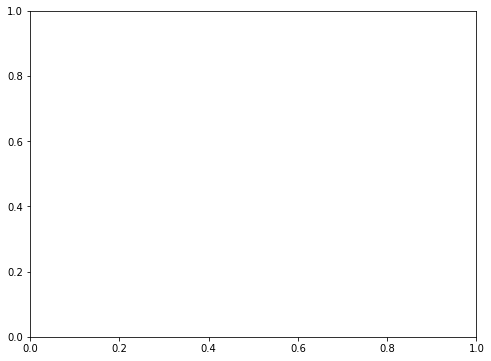

---------------------------------------------------------------------------
PandasNotImplementedError                 Traceback (most recent call last)
File <command-268916329659125>:22
     17     pandas_df_melt[(pandas_df_melt['Country Name'] == 'Afghanistan') | 
     18                     (pandas_df_melt['Country Name'] == 'Albania') | 
     19                     (pandas_df_melt['Country Name'] == 'Honduras')].groupby('Country Name').plot('year', column_name, legend=True, ax=ax)
     20     ax.legend(labels=['Afghanistan', 'Albania', 'Honduras'])
---> 22 plot_results('GDP')

File <command-268916329659125>:17, in plot_results(column_name)
     13 def plot_results(column_name):
     14     # plot the results for Afghanistan, Albania, and Honduras
     15     fig, ax = plt.subplots(figsize=(8,6))
---> 17     pandas_df_melt[(pandas_df_melt['Country Name'] == 'Afghanistan') | 
     18                     (pandas_df_melt['Country Name'] == 'Albania') | 
     19                     (pand

In [0]:
# Pandas

# Converting from wide to long format
# Putting every year column into one column for each country and finding associated GDPs 
pandas_df_melt = ps.melt(pandas_df_gdp, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], 
                            var_name='year', value_name='GDP')
print(f"Pandas melt output:\n{pandas_df_melt.head()}")

# convert year to a date time
pandas_df_melt['year'] = ps.to_datetime(pandas_df_melt['year'])

# ** pd.groupby.GroupBy.plot() functionality does not work on pyspark pandas
def plot_results(column_name):
    # plot the results for Afghanistan, Albania, and Honduras
    fig, ax = plt.subplots(figsize=(8,6))

    pandas_df_melt[(pandas_df_melt['Country Name'] == 'Afghanistan') | 
                    (pandas_df_melt['Country Name'] == 'Albania') | 
                    (pandas_df_melt['Country Name'] == 'Honduras')].groupby('Country Name').plot('year', column_name, legend=True, ax=ax)
    ax.legend(labels=['Afghanistan', 'Albania', 'Honduras'])
    
plot_results('GDP')

PySpark doesn't support plotting so it's better to convert to pandas and visualize. This is not efficient but normally PySpark is used to perform transformations, the output of which is stored in a data warehouse. From their, tools like PowerBi, Tableau, etc. for visualizing.

In [0]:
# Using spark

gdp_cols = df_gdp.columns[4:]  # Years columns start at index 4
stack_expr = ", ".join([f"'{col}', `{col}`" for col in gdp_cols])

df_gdp_long = df_gdp.selectExpr(
    "`Country Name`", 
    "`Country Code`", 
    "`Indicator Name`", 
    "`Indicator Code`",
    f"stack({len(gdp_cols)}, {stack_expr}) as (year, GDP)"
)

# Show the reshaped DataFrame
df_gdp_long.show()

+------------+------------+-----------------+--------------+----+----+
|Country Name|Country Code|   Indicator Name|Indicator Code|year| GDP|
+------------+------------+-----------------+--------------+----+----+
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1960|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1961|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1962|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1963|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1964|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1965|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1966|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1967|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1968|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1969|null|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1970|null|
|     

In [0]:
from pyspark.sql.functions import to_date

In [0]:
# Converting yead to datetime format
df_gdp_long = df_gdp_long.withColumn("year", to_date(df_gdp_long["year"], "yyyy"))

In [0]:
# Finding certain countries and converting the dataframe to pandas
pandas_df_gdp_long = df_gdp_long.filter(
    (df_gdp_long["Country Name"] == "Afghanistan") |
    (df_gdp_long["Country Name"] == "Albania") |
    (df_gdp_long["Country Name"] == "Honduras")
).toPandas()

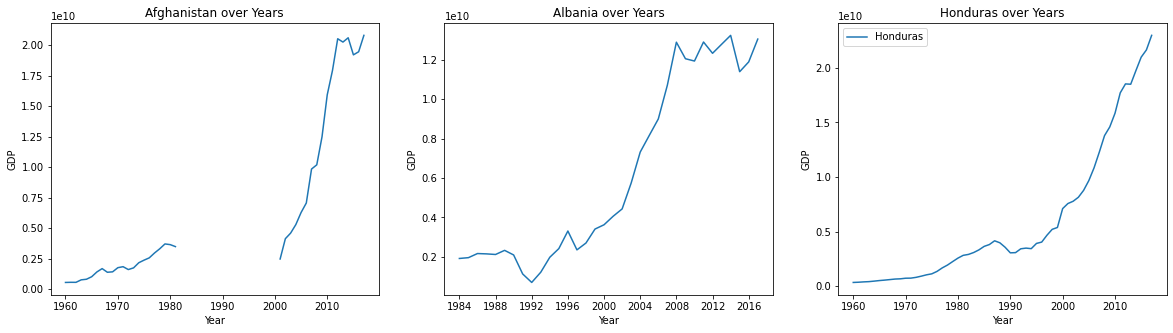

In [0]:
def plot_results(df, column_name):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    i = 0
    for country, group in df.groupby("Country Name"):
        # group.plot(x="year", y="GDP", ax=ax, label=country)
        ax[i].plot(group["year"], group[column_name].astype(float), label = country)
        ax[i].set_title(f"{country} over Years")
        ax[i].set_xlabel("Year")
        ax[i].set_ylabel("GDP")
        i = i + 1
    plt.legend()
    plt.show()

plot_results(pandas_df_gdp_long, "GDP")

Afghanistan and Albania are missing data, which show up as gaps in the results.

Exercise - Part 1

Calculating mean GDP for each country and filling in missing values with the country mean.

In [0]:
from pyspark.sql.functions import mean, coalesce

In [0]:
# Calculate mean of GDP column for each country
# df_gdp_long.agg(mean('GDP')).collect()[0][0]
mean_df_gdp = df_gdp_long.groupBy("Country Name").agg(mean("GDP").alias("mean_GDP"))

In [0]:
# Joining the dataframe with the calculated means with our gdp dataframe in long format
df_gdp_with_mean = df_gdp_long.join(mean_df_gdp, on="Country Name", how="left")
df_gdp_with_mean.show(n = 100)

+------------+------------+-----------------+--------------+----------+----------------+--------------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|            mean_GDP|
+------------+------------+-----------------+--------------+----------+----------------+--------------------+
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|537777811.111111| 6.620577542361928E9|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|548888895.555556| 6.620577542361928E9|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|546666677.777778| 6.620577542361928E9|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|751111191.111111| 6.620577542361928E9|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1964-01-01|800000044.444444| 6.620577542361928E9|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1965-01-01|1006666637.77778| 6.620577542361928E9|
| Afghanis

In [0]:
# Replacing GDP 
df_gdp_long = df_gdp_with_mean.withColumn("GDP_Filled", coalesce(df_gdp_long["GDP"], df_gdp_with_mean["mean_GDP"]))
df_gdp_long.show(n = 100)

+------------+------------+-----------------+--------------+----------+----------------+--------------------+--------------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|            mean_GDP|          GDP_Filled|
+------------+------------+-----------------+--------------+----------+----------------+--------------------+--------------------+
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|537777811.111111| 6.620577542361928E9|    537777811.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|548888895.555556| 6.620577542361928E9|    548888895.555556|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|546666677.777778| 6.620577542361928E9|    546666677.777778|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|751111191.111111| 6.620577542361928E9|    751111191.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1964-01-01|800000044.44

In [0]:
# Dropping the extra mean_gdp column from the dataframe
df_gdp_long = df_gdp_long.drop("mean_GDP")

+------------+------------+-----------------+--------------+----------+----------------+--------------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|          GDP_Filled|
+------------+------------+-----------------+--------------+----------+----------------+--------------------+
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|537777811.111111|    537777811.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|548888895.555556|    548888895.555556|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|546666677.777778|    546666677.777778|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|751111191.111111|    751111191.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1964-01-01|800000044.444444|    800000044.444444|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1965-01-01|1006666637.77778|    1006666637.77778|
| Afghanis

In [0]:
df_gdp_long.show(n = 100)

+------------+------------+-----------------+--------------+----------+----------------+--------------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|          GDP_Filled|
+------------+------------+-----------------+--------------+----------+----------------+--------------------+
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|            null|2.0363550589695833E9|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|            null|2.0363550589695833E9|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|            null|2.0363550589695833E9|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|            null|2.0363550589695833E9|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1964-01-01|            null|2.0363550589695833E9|
|       Aruba|         ABW|GDP (current US$)|NY.GDP.MKTP.CD|1965-01-01|            null|2.0363550589695833E9|
|       Ar

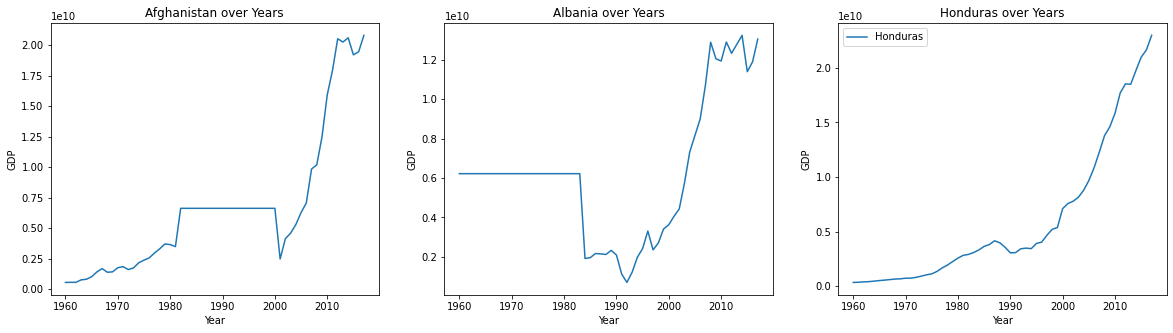

In [0]:
# Plot the results
pandas_df_gdp_long = df_gdp_long.filter(
    (df_gdp_long["Country Name"] == "Afghanistan") |
    (df_gdp_long["Country Name"] == "Albania") |
    (df_gdp_long["Country Name"] == "Honduras")
).toPandas()

plot_results(pandas_df_gdp_long, 'GDP_Filled')

Excercise - Part 2

Use the fillna forward fill method to fill in the missing data. Forwards fill replance None with the previous value in the column. Here is the documentation. (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html)

The pandas fillna method has a forward fill option. For example, if you wanted to use forward fill on the GDP dataset, you could execute df_melt['GDP'].fillna(method='ffill'). However, there are two issues with that code.

You want to first make sure the data is sorted by year
You need to group the data by country name so that the forward fill stays within each country
Write code to first sort the df_melt dataframe by year, then group by 'Country Name', and finally use the forward fill method.

In [0]:
# Pandas from the spark
pandas_df_gdp_long['GDP_ffill'] = pandas_df_gdp_long.sort_values('year').groupby('Country Name')['GDP'].fillna(method='ffill')
print(pandas_df_gdp_long.head(n = 10))

  Country Name Country Code     Indicator Name  Indicator Code        year  \
0  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960-01-01   
1  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961-01-01   
2  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962-01-01   
3  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963-01-01   
4  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964-01-01   
5  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1965-01-01   
6  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1966-01-01   
7  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1967-01-01   
8  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1968-01-01   
9  Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1969-01-01   

                GDP        GDP_Filled         GDP_ffill  
0  537777811.111111  537777811.111111  537777811.111111  
1  548888895.555556  5488

In [0]:
# Spark

from pyspark.sql.functions import last
from pyspark.sql.window import Window

In [0]:
gdp_window_over_country = (
    Window
    .partitionBy('Country Name')
    .orderBy('Year')
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)
)

df_gdp_long = (
    df_gdp_long
    .withColumn('GDP__ffill', last('GDP', ignorenulls = True).over(gdp_window_over_country))
)

df_gdp_long.show(n = 100)

+------------+------------+-----------------+--------------+----------+----------------+-------------------+----------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|         GDP_Filled|      GDP__ffill|
+------------+------------+-----------------+--------------+----------+----------------+-------------------+----------------+
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|537777811.111111|   537777811.111111|537777811.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|548888895.555556|   548888895.555556|548888895.555556|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|546666677.777778|   546666677.777778|546666677.777778|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|751111191.111111|   751111191.111111|751111191.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1964-01-01|800000044.444444|   800000044.444444|800000044.

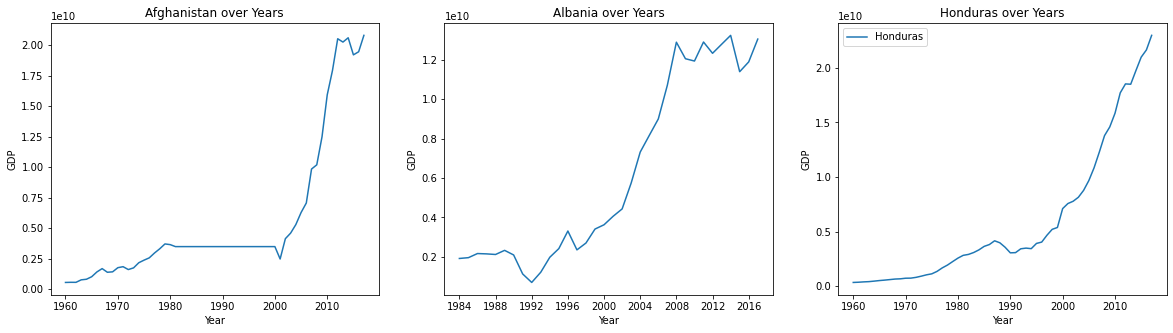

In [0]:
# Plotting the data
pandas_df_gdp_long = df_gdp_long.filter(
    (df_gdp_long["Country Name"] == "Afghanistan") |
    (df_gdp_long["Country Name"] == "Albania") |
    (df_gdp_long["Country Name"] == "Honduras")
).toPandas()

plot_results(pandas_df_gdp_long, 'GDP__ffill')

This looks better at least for the Afghanistan data; however, the Albania data is still missing values. You can fill in the Albania data using back fill. That is what you'll do next.

Exercise - Part 3

This part is similar to Part 2, but now you will use backfill. Write code that backfills the missing GDP data.

In [0]:
from pyspark.sql.functions import first

In [0]:
gdp_window_over_country = (
    Window
    .partitionBy('Country Name')  
    .orderBy('year')            
    .rowsBetween(Window.currentRow, Window.unboundedFollowing)  # Rows after the current row
)

df_gdp_long = (
    df_gdp_long
    .withColumn('GDP__bfill', first('GDP', ignorenulls = True).over(gdp_window_over_country))
)

df_gdp_long.show(n = 100)

+------------+------------+-----------------+--------------+----------+----------------+-------------------+----------------+----------------+
|Country Name|Country Code|   Indicator Name|Indicator Code|      year|             GDP|         GDP_Filled|      GDP__ffill|      GDP__bfill|
+------------+------------+-----------------+--------------+----------+----------------+-------------------+----------------+----------------+
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1960-01-01|537777811.111111|   537777811.111111|537777811.111111|537777811.111111|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1961-01-01|548888895.555556|   548888895.555556|548888895.555556|548888895.555556|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1962-01-01|546666677.777778|   546666677.777778|546666677.777778|546666677.777778|
| Afghanistan|         AFG|GDP (current US$)|NY.GDP.MKTP.CD|1963-01-01|751111191.111111|   751111191.111111|751111191.111111|751111191.111111|

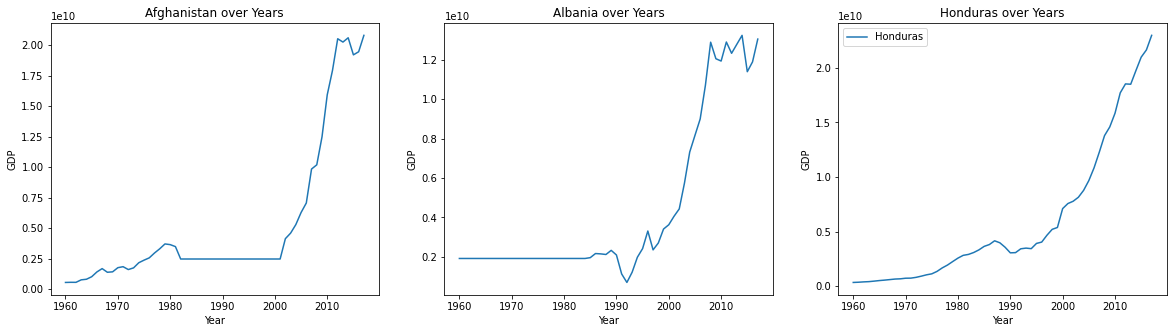

In [0]:
# Plotting the data
pandas_df_gdp_long = df_gdp_long.filter(
    (df_gdp_long["Country Name"] == "Afghanistan") |
    (df_gdp_long["Country Name"] == "Albania") |
    (df_gdp_long["Country Name"] == "Honduras")
).toPandas()

plot_results(pandas_df_gdp_long, 'GDP__bfill')

In this case, the GDP data for all three countries is now complete. Note that forward fill did not fill all the Albania data because the first data entry in 1960 was NaN. Forward fill would try to fill the 1961 value with the NaN value from 1960.

To completely fill the entire GDP data for all countries, you might have to run both forward fill and back fill. Note as well that the results will be slightly different depending on if you run forward fill first or back fill first. Afghanistan, for example, is missing data in the middle of the data set. Hence forward fill and back fill will have slightly different result

### Duplicate Data

A data set might have duplicate data: in other words, the same record is represented multiple times. Sometimes, it's easy to find and eliminate duplicate data like when two records are exactly the same. At other times, duplicate data is hard to spot.

From the World Bank GDP data, count the number of countries that have had a project totalamt greater than 1 billion dollars (1,000,000,000). To get the count, you'll have to remove duplicate data rows.

In [0]:
# Pandas

pandas_df_projects = ps.read_csv('/FileStore/tables/world_bank_data/projects_data.csv', dtype = str)
pandas_df_projects = pandas_df_projects.drop('_c56', axis = 1)
pandas_df_projects['totalamt'] = ps.to_numeric(pandas_df_projects['totalamt'].str.replace(',', ''))
pandas_df_projects['countryname'] = pandas_df_projects['countryname'].str.split(';').str.get(0)
pandas_df_projects['boardapprovaldate'] = ps.to_datetime(pandas_df_projects['boardapprovaldate'])

# Filtering the data frame for projects over 1 billion dollars
# Then counting the number of unique countries in the results
pandas_df_projects[pandas_df_projects['totalamt'] > 1000000000]['countryname'].nunique()

Out[75]: 17

In [0]:
from pyspark.sql.functions import split, col, regexp_replace

In [0]:
# Spark
df_projects = spark.read.csv("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")

# Setting the first row as the names of columns
# Step 1: Extract the first row (assuming it's the header row)
header_row = df_projects.first()

# Step 2: Convert the header row to a list
new_column_names = [str(col) for col in header_row]

# Step 3: Remove the header row from the DataFrame
df_without_header = df_projects.filter(df_projects[0] != header_row[0])

# Step 4: Rename columns using the extracted header row
df_projects = df_without_header.toDF(*new_column_names)

# Removing the last blank column
df_projects = df_projects.drop("None")

# Show the resulting DataFrame
df_projects.show()

+-------+--------------------+--------------------+--------+--------------------+----------------+------------------------+--------------------+---------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------------+-----------+-----------+-----------+----------+--------+---------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+------------+------------+------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|     id|          regionname|         countryname|prodline|        lendinginstr|lendinginstrtype|envassesmentcategorycode|supplementprojectflg|productlinetype|pr

In [0]:
# Correcting the data

# Removing comma from strings
df_projects = df_projects.withColumn("totalamt", regexp_replace(col("totalamt"), ",", ""))
# totalamt to float type
df_projects = df_projects.withColumn("totalamt", df_projects['totalamt'].cast(FloatType()))  

# "country;country" -> "country"
df_projects = df_projects.withColumn("countryname", split(col("countryname"), ";").getItem(0))  

# Board approval date to timestamp data type
df_projects = df_projects.withColumn('boardapprovaldate', to_timestamp(df_projects['boardapprovaldate']))

In [0]:
print(f"No. of countries having projects > $1 billion:-")
df_projects.filter(df_projects["totalamt"] > 1000000000).select("countryname").distinct().count()

No. of countries having projects > $1 billion:-
Out[106]: 17

### Dummy Variables

In this exercise, I'll create dummy variables from the projects data set. The idea is to transform categorical data like this:

| Project ID | Project Category |
| --- | --- |
| 0 | Energy |
| 1 | Transportation |
| 2 | Health |
| 3 | Employment |

into new features that look like this:

| Project ID	| Energy | Transportation	| Health	 |Employment |
| --- | --- | --- | --- | --- |
|0|1|0|0|0|
|1|0|1|0|0|
|2|0|0|1|0|
|3|0|0|0|1|

(Note if you were going to use this data with a model influenced by multicollinearity, you would want to eliminate one of the columns to avoid redundant information.)

The reasoning behind these transformations is that machine learning algorithms read in numbers not text. Text needs to be converted into numbers. You could assign a number to each category like 1, 2, 3, and 4. But a categorical variable has no inherent order, so you want to reflect this in your features.

Pandas makes it very easy to create dummy variables with the get_dummies method. In this exercise, you'll create dummy variables from the World Bank projects data; however, there's a caveat. The World Bank data is not particularly clean, so you'll need to explore and wrangle the data first.

You'll focus on the text values in the sector variables.


In [0]:
from pyspark.sql.functions import split, col, regexp_replace, to_timestamp, year, monotonically_increasing_id

In [0]:
# Pandas

pandas_df_projects = ps.read_csv('/FileStore/tables/world_bank_data/projects_data.csv', dtype = str)
pandas_df_projects = pandas_df_projects.drop('_c56', axis = 1)
pandas_df_projects['totalamt'] = ps.to_numeric(pandas_df_projects['totalamt'].str.replace(',', ''))
pandas_df_projects['countryname'] = pandas_df_projects['countryname'].str.split(';').str.get(0)
pandas_df_projects['boardapprovaldate'] = ps.to_datetime(pandas_df_projects['boardapprovaldate'])

pandas_sector = pandas_df_projects.copy()
pandas_sector = sector[['project_name', 'lendinginstr', 'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
          'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
          'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
          'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
          'mjtheme4name', 'mjtheme5name']]

In [0]:
pandas_df_projects.columns

Out[49]: Index(['id', 'regionname', 'countryname', 'prodline', 'lendinginstr',
       'lendinginstrtype', 'envassesmentcategorycode', 'supplementprojectflg',
       'productlinetype', 'projectstatusdisplay', 'status', 'project_name',
       'boardapprovaldate', 'board_approval_month', 'closingdate',
       'lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt',
       'borrower', 'impagency', 'url', 'projectdoc ', 'majorsector_percent ',
       'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
       'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
       'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
       'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
       'mjtheme4name', 'mjtheme5name', 'location', 'GeoLocID', 'GeoLocName',
       'Latitude', 'Longitude', 'Country'],
      dtype='object')

In [0]:
# Spark
df_projects = spark.read.csv("dbfs:/FileStore/tables/world_bank_data/projects_data.csv")

# Setting the first row as the names of columns
# Step 1: Extract the first row (assuming it's the header row)
header_row = df_projects.first()

# Step 2: Convert the header row to a list
new_column_names = [str(col) for col in header_row]

# Step 3: Remove the header row from the DataFrame
df_without_header = df_projects.filter(df_projects[0] != header_row[0])

# Step 4: Rename columns using the extracted header row
df_projects = df_without_header.toDF(*new_column_names)

# Removing the last blank column
df_projects = df_projects.drop("None")

In [0]:
# Correcting the data

# Removing comma from strings
df_projects = df_projects.withColumn("totalamt", regexp_replace(col("totalamt"), ",", ""))
# totalamt to float type
df_projects = df_projects.withColumn("totalamt", df_projects['totalamt'].cast(FloatType()))  

# "country;country" -> "country"
df_projects = df_projects.withColumn("countryname", split(col("countryname"), ";").getItem(0))  

# Board approval date to timestamp data type
df_projects = df_projects.withColumn('boardapprovaldate', to_timestamp(df_projects['boardapprovaldate']))

In [0]:
# List of columns to select
columns_to_select = [
    'project_name', 'lendinginstr', 'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'sector',
    'mjsector1', 'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5',
    'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 'theme5', 'theme ',
    'goal', 'financier', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
    'mjtheme4name', 'mjtheme5name'
]

# Select the desired columns
sector = df_projects.select(*columns_to_select)
sector.show(n = 5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+------------+------------+------------+------------+
|        project_name|        lendinginstr|             sector1|             sector2|             sector3|             sector4|sector5|              sector|mjsector1|mjsector2|mjsector3|mjsector4|mjsector5|            mjsector|theme1|theme2|theme3|theme4|theme5|theme |goal|financier|mjtheme1name|mjtheme2name|mjtheme3name|mjtheme4name|mjtheme5name|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+---------+---------+---------+---------+--------------------+------+------+------+------+------+------+----+---------+------------+---

The cell below shows the percentage of each variable that is null. Notice the mjsector1 through mjsector5 variables are all null. The mjtheme1name through mjtheme5name are also all null as well as the theme variable.

Because these variables contain so many null values, they're probably not very useful

In [0]:
pandas_sector.head()

Out[53]: Row(project_name=' Creating a Trade in Value-Added Database for Africa', lendinginstr='Investment Project Financing', sector1=None, sector2=None, sector3=None, sector4=None, sector5=None, sector=None, mjsector1=None, mjsector2=None, mjsector3=None, mjsector4=None, mjsector5=None, mjsector=None, theme1='!$!0', theme2=None, theme3=None, theme4=None, theme5=None, theme =None, goal=None, financier=None, mjtheme1name=None, mjtheme2name=None, mjtheme3name=None, mjtheme4name=None, mjtheme5name=None)

In [0]:
# Pandas
# Output percentage of values that are missing
# 100 * pandas_sector.isnull().sum() / pandas_sector.shape[0]
100 * pandas_sector.apply(lambda col: (col == "None")).sum() / pandas_sector.shape[0]       # Null is read as 'None' strings

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-1964087950149634>:4
      1 # Pandas
      2 # Output percentage of values that are missing
      3 # 100 * pandas_sector.isnull().sum() / pandas_sector.shape[0]
----> 4 100 * pandas_sector.apply(lambda col: (col == "None")).sum() / pandas_sector.shape[0]

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:2964, in DataFrame.__getattr__(self, name)
   2934 """Returns the :class:`Column` denoted by ``name``.
   2935 
   2936 .. versionadded:: 1.3.0
   (.

In [0]:
# Spark

sector.select([ (sum(col(c).isNull().cast("int"))  / sector.count()*100).alias(c) for c in sector.columns]).show()

+------------+------------------+-------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+---------+---------+---------+---------+-----------------+------+------------------+-----------------+-----------------+-----------------+------+-----------------+------------------+------------+------------+------------+------------+------------+
|project_name|      lendinginstr|sector1|          sector2|          sector3|          sector4|          sector5|           sector|mjsector1|mjsector2|mjsector3|mjsector4|mjsector5|         mjsector|theme1|            theme2|           theme3|           theme4|           theme5|theme |             goal|         financier|mjtheme1name|mjtheme2name|mjtheme3name|mjtheme4name|mjtheme5name|
+------------+------------------+-------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+---------+---------+---------+---------+-----------------+------+----------------

The sector1 variable looks promising; it doesn't contain any null values at all. In the next cell, store the unique sector1 values in a list and output the results. Use the sort_values() and unique() methods.

In [0]:
# pandas
# Create a list of the unique values in sector1. Use the sort_values() and unique() pandas methods. 
# And then convert those results into a Python list
pandas_uniquesectors1 = pandas_sector['sector1'].sort_values().unique()
pandas_uniquesectors1

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-1964087950149641>:4
      1 # pandas
      2 # Create a list of the unique values in sector1. Use the sort_values() and unique() pandas methods. 
      3 # And then convert those results into a Python list
----> 4 pandas_uniquesectors1 = pandas_sector['sector1'].sort_values().unique()
      5 pandas_uniquesectors1

TypeError: 'Column' object is not callable

In [0]:
# run this code cell to see the number of unique values
print('Number of unique values in sector1:', len(pandas_uniquesectors1))

Number of unique values in sector1: 3060


In [0]:
# Spark
unique_name_list = [row["sector1"] for row in sector.select("sector1").distinct().collect()]
print(f"No. of unique values: {len(unique_name_list)}")
print(f"Unique values: {unique_name_list}")

No. of unique values: 3060
Unique values: ['Health!$!69!$!HG', 'Workforce Development and Vocational Education!$!44!$!EW', 'Agricultural markets; commercialization and agri-business!$!59!$!YA', 'ICT Services!$!23!$!CS', 'Public Administration - Water; Sanitation and Waste Management!$!53!$!WF', 'Banking Institutions!$!74!$!FA', 'Health!$!100!$!HG', 'Primary Education!$!55!$!EP', 'Secondary Education!$!31!$!ES', 'Workforce Development and Vocational Education!$!48!$!EW', 'Other Agriculture; Fishing and Forestry!$!84!$!AZ', 'Primary Education!$!83!$!EP', 'Other Agriculture; Fishing and Forestry!$!43!$!AZ', 'Other Agriculture; Fishing and Forestry!$!39!$!AZ', 'Crops!$!63!$!AH', 'Public Administration - Water; Sanitation and Waste Management!$!57!$!WF', 'Other Industry; Trade and Services!$!49!$!YZ', 'Irrigation and Drainage!$!94!$!AI', 'Mining!$!29!$!LM', 'Rural and Inter-Urban Roads!$!85!$!TI', 'Irrigation and Drainage!$!44!$!AI', 'Sanitation!$!44!$!WA', 'Public Administration - Agricult

There are a few issues with this 'sector1' variable. First, there are values labeled '!$!0'. These should be substituted with NaN.

Furthermore, each sector1 value ends with a ten or eleven character string like '! 
!
49
!
 !EP'. Some sectors show up twice in the list like: 'Other Industry; Trade and Services! 
!
70
!
 !YZ', 'Other Industry; Trade and Services! 
!
63
!
 !YZ',

But it seems like those are actually the same sector. You'll need to remove everything past the exclamation point.

Many values in the sector1 variable start with the term '(Historic)'. Try removing that phrase as well

**replace() method**

With pandas, you can use the replace() method to search for text and replace parts of a string with another string. If you know the exact string you're looking for, the replace() method is straight forward. For example, say you wanted to remove the string '(Trial)' from this data:

| data |
| --- |
'(Trial) Banking'
'Banking'
'Farming'
'(Trial) Transportation'

You could use df['data'].replace('(Trial'), '') to replace (Trial) with an empty string.

**regular expressions**

What about this data?

| data |
| --- |
'Other Industry; Trade and Services?$ab'
'Other Industry; Trade and Services?ceg'

This type of data is trickier. In this case, there's a pattern where you want to remove a string that starts with an exclamation point and then has an unknown number of characters after it. When you need to match patterns of character, you can use regular expressions.

The replace method can take a regular expression. So df['data'].replace('?.+', regex=True) where '?.+' means find a set of characters that starts with a question mark is then followed by one or more characters. You can see a regular expression cheat sheet here.

In [0]:
# Pandas
# In the sector1 variable, replace the string '!$10' with nan
pandas_sector['sector1'] = pandas_sector['sector1'].replace('!$!0', np.nan)

# In the sector1 variable, remove the last 10 or 11 characters from the sector1 variable.
# There is more than one way to do this including the replace method
# You can use a regex expression '!.+'
# That regex expression looks for a string with an exclamation
# point followed by one or more characters
pandas_sector['sector1'] = pandas_sector['sector1'].replace('!.+', '', regex=True)

# Remove the string '(Historic)' from the sector1 variable
# You can use the replace method
pandas_sector['sector1'] = pandas_sector['sector1'].replace('^(\(Historic\))', '', regex=True)

print('Number of unique sectors after cleaning:', len(list(pandas_sector['sector1'].unique())))
print('Percentage of null values after cleaning:', 100 * pandas_sector['sector1'].apply(lambda col: (col == "None")).sum() / pandas_sector.shape[0])

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-2057470016478297>:3
      1 # Pandas
      2 # In the sector1 variable, replace the string '!$10' with nan
----> 3 pandas_sector['sector1'] = pandas_sector['sector1'].replace('!$!0', np.nan)
      5 # In the sector1 variable, remove the last 10 or 11 characters from the sector1 variable.
      6 # There is more than one way to do this including the replace method
      7 # You can use a regex expression '!.+'
      8 # That regex expression looks for a string with an exclamation
      9 # point followed by one or more characters
     10 pandas_sector['sector1'] = pandas_sector['sector1'].replace('!.+', '', regex=True)

TypeError: 'Column' object is not callable

In [0]:
# Spark
# Replacing all '!$!0' with null/NaN
sector = sector.withColumn(
    "sector1",
    when(regexp_replace(col("sector1"), "!\\$!0", "") == col("sector1"), col("sector1"))
    .otherwise(lit(None))  # Replace matches with null (NaN equivalent in Spark)
)

# Replacing any expression having a ! followed by digits with 
sector = sector.withColumn("sector1", regexp_replace(col("sector1"), "!.+", ""))

# Remove the string '(Historic)' from the sector1 variable
# You can use the replace method
sector = sector.withColumn("sector1", regexp_replace(col("sector1"), "^(\(Historic\))", ""))

unique_name_list = [row["sector1"] for row in sector.select("sector1").distinct().collect()]
print(f"No. of unique values: {len(unique_name_list)}")

No. of unique values: 156


In [0]:
print("Percentage of null values in 'sector1' column:-")
sector.select([ (sum(col("sector1").isNull().cast("int"))  / sector.count()*100).alias("sector1_percentage_null")]).show()

Percentage of null values in 'sector1' column:-
+-----------------------+
|sector1_percentage_null|
+-----------------------+
|      3.496273564226217|
+-----------------------+



Now there are 156 unique categorical values. That's better than 3060. If you were going to use this data with a supervised learning machine model, you could try converting these 156 values to dummy variables. You'd still have to train and test a model to see if those are good features.

In this next exercise, I use the StringIndexer and OneHotEncoder method to a one hot encoding for sector1 values. Then I use the join() method to join the new dataframe to another dataframe that contains the project totalamt variable and the project year from the boardapprovaldate.

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [0]:
sector_unknown = sector.na.fill({"sector1": "unknown"})  # Replace nulls with 'unknown' to prevent StringIndexer from giving error

In [0]:
indexer = StringIndexer(inputCol = "sector1", outputCol = "sector1_indexed")
sector_indexed = indexer.fit(sector_unknown).transform(sector_unknown)
# sector_indexed.select("sector1", "sector1_indexed").show(n = 100)

encoder = OneHotEncoder(inputCol = "sector1_indexed", outputCol = "sector1_onehot")
sector_encoded = encoder.fit(sector_indexed).transform(sector_indexed)
sector_encoded.select("sector1", "sector1_indexed", "sector1_onehot").show(truncate=False)

+-----------------+---------------+---------------+
|sector1          |sector1_indexed|sector1_onehot |
+-----------------+---------------+---------------+
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|Social Protection|2.0            |(155,[2],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown          |3.0            |(155,[3],[1.0])|
|unknown    

In [0]:
df_projects = df_projects.withColumn("year", year(df_projects["boardapprovaldate"]))
# df_projects_final.withColumn("totalamt", df_projects.select("totalamt"))
df_projects_final = df_projects.select("totalamt", "year")
df_projects_final = df_projects_final.withColumn("index", monotonically_increasing_id())

df_projects_final = df_projects_final.join(sector_encoded.withColumn("index",monotonically_increasing_id()).select("index", "sector1", "sector1_indexed", "sector1_onehot"), on = "index").drop("index")
df_projects_final.show()

+--------+----+-----------------+---------------+---------------+
|totalamt|year|          sector1|sector1_indexed| sector1_onehot|
+--------+----+-----------------+---------------+---------------+
|     0.0|2018|          unknown|            3.0|(155,[3],[1.0])|
|   2.0E8|2018|          unknown|            3.0|(155,[3],[1.0])|
| 5.833E7|2018|          unknown|            3.0|(155,[3],[1.0])|
|   2.0E7|2018|          unknown|            3.0|(155,[3],[1.0])|
|   1.0E8|2018|Social Protection|            2.0|(155,[2],[1.0])|
|   5.0E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|   3.5E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|  2.25E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|  1.25E8|2018|          unknown|            3.0|(155,[3],[1.0])|
| 3.299E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|   2.0E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|   4.0E8|2018|          unknown|            3.0|(155,[3],[1.0])|
|     0.0|

### Finding Outliers

In [0]:
# TO DO